In [15]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]
def get_contig_lengths(file):
    contig_len = {}
    for line in file:
        contig, length = line.split()
        length = int(length)
        if contig in contig_len:
            print("Error: double cont: " + contig + " | v1: " + str(contig_len[contig]) + " | v2: " + str(length))
        contig_len[contig] = length
    return contig_len

def read_file(file_name):
    """
    """
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            data.append([a, b, float(dist)])
    return data

def wandle_datei_um_rev(file, out_name, contig_len):
    out = open(out_name,'w')
    lines = []
    for line in file:
        b, a, dist = line.split()
        
      #  if float(dist) + contig_len[b] + contig_len[a]< 0:
       #     print(a,b,dist)
        dist = float(dist) + contig_len[a]
        if dist < 0:
            a, b = b, a
            dist = - dist
        lines.append(a+'_0\t'+b+'_0\t'+str(dist)+'\n')
       # if a == b:
            #print(a,b,dist)
    lines.sort()
    out.writelines(lines)
    out.close()
    
def wandle_datei_um(file, out_name, contig_len):
    out = open(out_name,'w')
    lines = []
    for line in file:
        a, b, dist = line.split()
        
      #  if float(dist) + contig_len[b] + contig_len[a]< 0:
       #     print(a,b,dist)
        dist = float(dist) + contig_len[a]
        if dist < 0:
            a, b = b, a
            dist = - dist
        lines.append(a+'_0\t'+b+'_0\t'+str(dist)+'\n')
       # if a == b:
            #print(a,b,dist)
    lines.sort()
    out.writelines(lines)
    out.close()
    
def write_file(file_name, data):
    with open(file_name, 'w') as out:
        for a,b,dist in data:
            out.write(a +'\t'+ b +'\t'+str(dist) +'\n')
            
def write_sol(file_name, pos):
    pos = sorted(pos.items(), key = lambda x: x[1])
    with open(file_name, 'w') as out:
        for contig, position in pos:
            out.write(contig +'\t'+ str(position) + '\n')
            
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
            
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)

    return position, contig_repeat
            
def sortiere_repeats(position, contig_repeat):
    
    for contig,repeats in contig_repeat.items():
        if len(repeats) == 1:
            continue
        
        for rep, pos in zip(repeats, sorted([position[rep] for rep in repeats])):
            position[rep] = pos
            
def get_vars(data):
    contigs = set()
    for a, b, _ in data:
        contigs.add(a)
        contigs.add(b)
    return contigs

def find(x, i):
    
    l = [i]
    while i in x and i != x[i]:
        i = x[i]
        l += [i]
    
    for j in l:
        x[j] = i
        
    return i

def union(x,i,j):
    i = find(x,i)
    j = find(x,j)
    x[i] = j
        
def to_sets(struct):
    sets = coll.defaultdict(set)
    for element in struct:
        root = find(struct, element)
        sets[root].add(element)
    return sorted(sets.values(), key = lambda x: len(x), reverse = True)

def connected(data):
    struct = {}
    for a, b, _ in data:
        union(struct, a, b)
    sets = to_sets(struct)
    
    if len(sets) == 1:
        print('Die Daten sind zusammenhängend')
    else:
        print('Es gibt unzusammenhängende Regionen in den Daten')
        value = round(100 * len(sets[0]) / sum(len(x) for x in sets), 2)
        print(str(value) + '% der Contigs sind in der größten Komponente.')
       # print(sum(len(x) for x in sets[1:]))
       #print(sum(len(x) for x in sets[:]))
        
    return [constraint for constraint in data if constraint[0] in sets[0]]
#connected('my_apd200.lst')


def solve_LP(position, graph, folgende):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(folgende)
    
    contig.update(position)
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in graph.edges:
        eps = model.addVar()
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= eps ) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps ) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in folgende}


def entferne_sackgassen(graph, start = '2345APD_0', ziel = '2080APD_0'):
    änderungen = True
    while änderungen:
        änderungen = False
        for x in list(graph):
            if graph.in_degree[x] == 0 and x != start:
                graph.remove_node(x)
                änderungen = True
            elif graph.out_degree[x] == 0 and x != ziel:
                graph.remove_node(x)
                änderungen = True
                
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName


def plot_graph(position, data, X = set(), E = set(), repeat = '', von = 0, bis = 400, kantenanzahl = 2, fehler = 1000):
    useIntName = True
    intName = get_intName(position)
    
    s = coll.defaultdict(set)
    p = coll.defaultdict(set)
    s = coll.defaultdict(coll.Counter)
    p = coll.defaultdict(coll.Counter)

    graph = nx.DiGraph() 
    for c in X:
        c_name = intName[c]
        if c in intNameX:
            c_name = (c_name, intNameX[c])
        if contig_name(c) == repeat:
            graph.add_node(c_name, color = 'green')
        else:
            if useIntName:
                graph.add_node(c_name, color = 'red')
            else:
                graph.add_node(contig_name(c), color = 'red')
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a][b] += 1
            p[b][a] += 1
            continue
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    ss2 = {a: sorted(s[a], key = lambda x: intName[x])[-1] for a in s}
    pp2 = {a: sorted(p[a], key = lambda x: intName[x])[0] for a in p}
    
    
    for b in pp:
        for a in pp[b]:
            
            b_name = intName[b]
            if b in intNameX:
                b_name = (b_name, intNameX[b])
            a_name = intName[a]
            if a in intNameX:
                a_name = (a_name, intNameX[a])
            if useIntName:
                graph.add_edge(a_name,b_name)
            else:
                graph.add_edge(contig_name(a),contig_name(b),label = s[a][b])
               # graph.add_edge(contig_name(a),contig_name(b))
    for a in ss:
        for b in ss[a]:
            b_name = intName[b]
            if b in intNameX:
                b_name = (b_name, intNameX[b])
            a_name = intName[a]
            if a in intNameX:
                a_name = (a_name, intNameX[a])
            if useIntName:
                graph.add_edge(a_name,b_name)
            else:
               # graph.add_edge(contig_name(a),contig_name(b))
                graph.add_edge(contig_name(a),contig_name(b),label = s[a][b])

    for a,b,d,g in E:
        b_name = intName[b]
        if b in intNameX:
            b_name = (b_name, intNameX[b])
        a_name = intName[a]
        if a in intNameX:
            a_name = (a_name, intNameX[a])
        if useIntName:
            graph.add_edge(a_name,b_name,color = 'green')
        else:
            graph.add_edge(contig_name(a),contig_name(b),color = 'green')
    """
    for a, b in ss2.items():
        if pp2[b] == a:
            b_name = intName[b]
            if b in intNameX:
                b_name = (b_name, intNameX[b])
            a_name = intName[a]
            if a in intNameX:
                a_name = (a_name, intNameX[a])
            if useIntName:
                graph.add_edge(a_name,b_name,color = 'green')
            else:
                graph.add_edge(contig_name(a),contig_name(b),color = 'green')
    """    
    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
    display(Image(filename='t.png'))

def plot_graph_(position, data, von = 0, bis = 4000, kantenanzahl = 1, fehler = 500):
    
    graph = nx.DiGraph() 
    intName = get_intName(position)
    
    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    for el in pp:
        for pr in pp[el]:
            graph.add_edge(intName[pr],intName[el])
           # graph.add_edge(pr,el)
    for el in ss:
        for su in ss[el]:
          #  graph.add_edge(el,su)
            graph.add_edge(intName[el],intName[su])

    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
   # display(Image(filename='t.png'))
    
def sub(al, bl, dist, tol = 1000):
    k = iter(bl)
    for i in al:
        i += dist
        try:
            e = next(k)
            while e < i - tol:
                e = next(k)
            if e > i + tol:
                return True
        except:
            return True
    return False

def b_dom_a(aneig,bneig,abdist):
    for c, la in aneig.items():
        if sub(la, bneig[c],abdist):
            return False
    return True

def überdeckte(graph):
    neigh = {}
    for b in graph:
        neigh[b] = coll.defaultdict(list)
        for a, l in graph.pred[b].items():
            neigh[b][a] = sorted([-d for d in l])
        neigh[b][b].append(0)
        for c, l in graph.succ[b].items():
            neigh[b][c] += sorted([d for d in l])
        neigh[b] = dict(neigh[b])
        
        
    evil = set()
    
    for a, aneig in neigh.items():
        for b, l in aneig.items():
            
            if len(l) > 1 or a == b:
                continue
                
            bneig = neigh[b]
            if not set(aneig) <= set(bneig):
                continue
                
            abdist = l[0]
            if b_dom_a(aneig,bneig,abdist):
                evil.add(a)
    return evil


def mehrfach(adj):
    for b,l in adj.items():
        if len(l) > 1:
            return True
    return False

def singels(graph):
    evil = []
    for a in graph:
        if mehrfach(graph.succ[a]) or mehrfach(graph.pred[a]):
            continue
        evil.append(a)
    return evil
pos, rep = read_position('apdsolution_coords.lst')
sortiere_repeats(pos, rep)
intNameX = get_intName(pos)
reps = {r+'_0' for r in rep if len(rep[r])>1}
        
def umsortieren(data, repeats, position):
    counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
          #  print('not',a, b, dist)
            continue
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print()

In [186]:

contig_len = get_contig_lengths(open('APDContigs.len'))
print(max(contig_len.values()))
print(min(contig_len.values()))
print(np.std(list(contig_len.values())))
wandle_datei_um(open('apd6.lst'), 'my_apd1998.lst', contig_len)

28764
111
2669.3421180504056


In [14]:
data2 = read_file('my_apd199.lst')
data2 = [[a,b,d] for a,b,d in data2 if a in pos and b in pos]
umsortieren(data2, rep, pos)

Anzahl der Änderungen: 4393



In [129]:
def plot_graph_(position, data, rep, von = 0, bis = 4000, kantenanzahl = 1, fehler = 500):
    
    graph = nx.DiGraph() 
    intName = get_intName(position)
    
    s = coll.defaultdict(coll.Counter)
    p = coll.defaultdict(coll.Counter)

    for ra, rb, dist in data:
        ra = contig_name(ra)
        rb = contig_name(rb)
        for a, b in it.product(rep[ra],rep[rb]):
            if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
                continue
            real_dist = position[b] - position[a]
            if abs(real_dist - dist) < fehler and a != b:
                if position[a] > position[b]:
                    a, b, real_dist = b, a, -real_dist
                s[a][b] += 1
                p[b][a] += 1
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    for el in p:
        for pr in p[el]:
            graph.add_node(pr,label = pr[:-2])
            graph.add_node(el,label = el[:-2])
            graph.add_edge(pr,el,label = s[pr][el])
          #  graph.add_edge(intName[pr],intName[el])
    for el in ss:
        for su in ss[el]:
            graph.add_node(su,label = su[:-2])
            graph.add_node(el,label = el[:-2])
            graph.add_edge(el,su,label = s[el][su])
          #  graph.add_edge(intName[el],intName[su])
    return graph
    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
    display(Image(filename='t.png'))

In [134]:

graph2 = plot_graph_(pos, data2,rep, von = 0, bis = 14108, kantenanzahl=1, fehler = 400)

In [135]:
graph = graph2.copy()
print(len(graph.edges()))
for a,b,g in list(graph.edges(data = 'label')):
    if g < 2:
        graph.remove_edge(a,b)
print(len(graph.edges()))

40023
17111


In [136]:
i = -1
for k in nx.weakly_connected_components(graph):
    if len(k)<3:
        for n in k:
            graph2.remove_node(n)
for k in nx.weakly_connected_components(graph2):
    print(len(k))

1917


In [128]:
len(get_vars(data1))

2124

In [96]:
data1 = read_file('my_apd199.lst')

In [138]:
g = nx.MultiDiGraph()
for a,b,d in data1:
    g.add_edge(a,b,d)

In [42]:
for x in nx.weakly_connected_components(g):
    if len(x)< 10:
        print(x)

{'2106APD_0'}
{'2179APD_0', '2143APD_0'}


In [147]:
data4 = [[a,b,d] for d,a,b,g in data3 if g > 1]
umsortieren(data4,rep,pos)

Anzahl der Änderungen: 425



In [178]:
i = 0
j = 0
k = 0
for a,b,d in data4:
    k += 1
    if not b in pos or not a in pos:
        i += 1
        continue
    if not -10000 <= pos[b] - pos[a] - d <= 10000:
        j += 1

(i+j)/k

0.03402708952758507

In [188]:
data = read_file('my_apd1998.lst')

In [189]:
for a,b,d in data:
    if a == '1763APD_0' or b == '1763APD_0':
        print(a,b,d)

1078APD_0 1763APD_0 16423.0
1078APD_0 1763APD_0 16439.0
1078APD_0 1763APD_0 16467.0
123APD_0 1763APD_0 20306.0
123APD_0 1763APD_0 21576.0
1260APD_0 1763APD_0 3169.0
1260APD_0 1763APD_0 3171.0
1260APD_0 1763APD_0 3171.0
1260APD_0 1763APD_0 3171.0
1260APD_0 1763APD_0 3171.0
1260APD_0 1763APD_0 3171.0
1260APD_0 1763APD_0 3171.0
1260APD_0 1763APD_0 3171.0
1260APD_0 1763APD_0 3171.0
1260APD_0 1763APD_0 3183.973913480004
1705APD_0 1763APD_0 10225.0
1705APD_0 1763APD_0 10242.0
1705APD_0 1763APD_0 10262.0
1705APD_0 1763APD_0 10279.0
1705APD_0 1763APD_0 10328.0
1763APD_0 1100APD_0 1921.0
1763APD_0 1100APD_0 2164.0
1763APD_0 1100APD_0 2218.0
1763APD_0 1100APD_0 2229.0
1763APD_0 1100APD_0 2246.0
1763APD_0 1100APD_0 2252.0
1763APD_0 1100APD_0 2257.0
1763APD_0 1212APD_0 2697.0
1763APD_0 1212APD_0 2988.0
1763APD_0 1212APD_0 2998.0
1763APD_0 1212APD_0 3012.0
1763APD_0 1212APD_0 3028.0
1763APD_0 1212APD_0 3039.0
1763APD_0 1222APD_0 1475.0
1763APD_0 1222APD_0 1733.0
1763APD_0 1222APD_0 1788.0
1763APD_0

In [140]:
i = 0
j = 0
for x in g:
    if g.degree(x) == 1 and x in pos:
        print(x[:-2])
    
    if g.out_degree(x) == 0:
        j += 1
print(i,j,i+j)

1763APD
1560APD
1608APD
158APD
1731APD
1833APD
621APD
916APD
571APD
800APD
1584APD
1360APD
2188APD
237APD
1121APD
1119APD
372APD
495APD
0 30 30


In [22]:
pos = {}
intNameX = {}

In [26]:

def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups

data2 = read_file('my_apd1998.lst')
data2 = connected(data2)
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
len(data3)

Es gibt unzusammenhängende Regionen in den Daten
99.63% der Contigs sind in der größten Komponente.
len z[x] 143416
len Z[x]  63766
len C     56692
len Z-C    7074
len z-Z   79650


63766

In [30]:
data4 = [[a,b,d] for d,a,b,g in data3 if g>1]
data4 = connected(data4)

Die Daten sind zusammenhängend


In [33]:

g3 = nx.MultiDiGraph() 
for a, b, d in data4:
    if a != b:
        g3.add_edge(a,b,d)
print(len(g3))
i = 0
for a in g3:
    if g3.in_degree(a) == 0:
        i+= 1
    elif g3.out_degree(a) == 0:
        i+= 1
print(i)
entferne_sackgassen(g3)
print(len(g3))

2105
25
2078


In [36]:
S = set(g3)

In [38]:
data2 = [[a,b,d] for a,b,d in data2 if a in S and b in S]
data3 = [[d,a,b,g] for d,a,b,g in data3 if a in S and b in S]

137717
63396
B 87
B 130
B 213
B 245
B 253
B 255
B 263
B 292
B 426
B 438
B 447
B 459
B 462
T [2]
2324APD_0


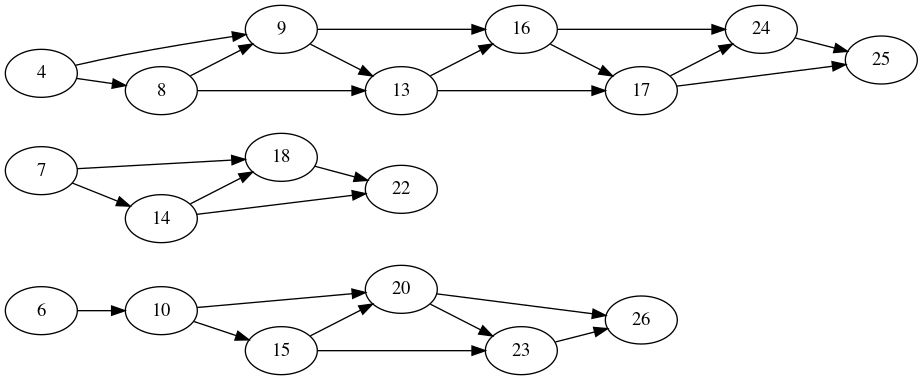

2324APD_0


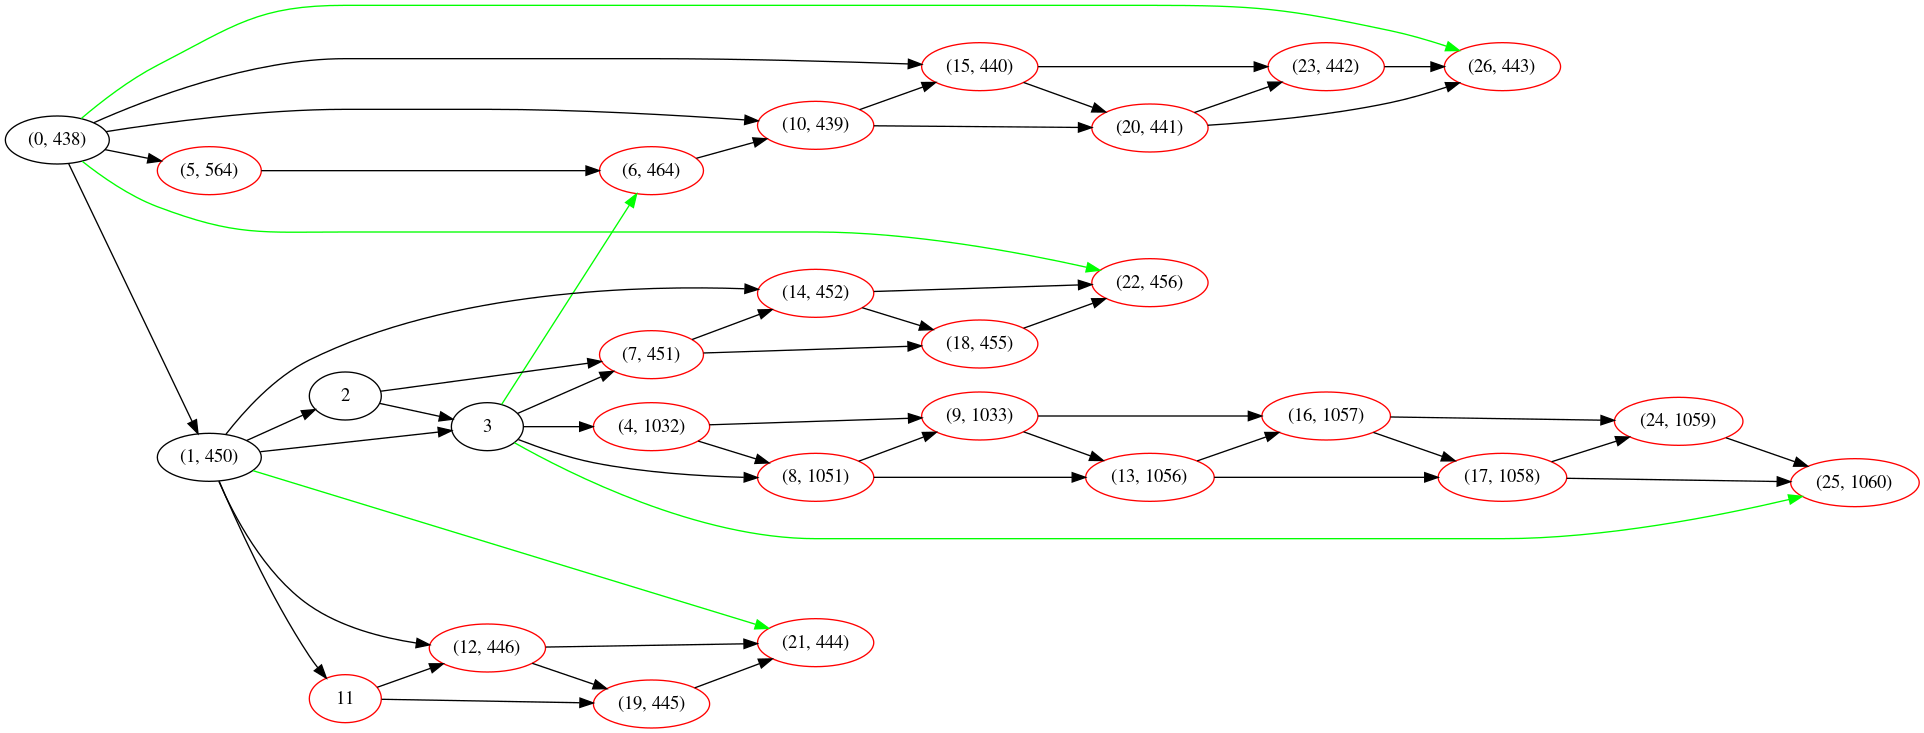

B 463
B 467
B 479
B 480
B 482
B 484
B 490
B 494
B 497
B 499
T [2, 1]
2278APD_0


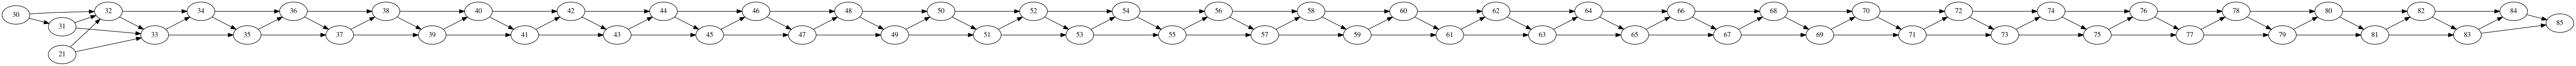

2278APD_0
447


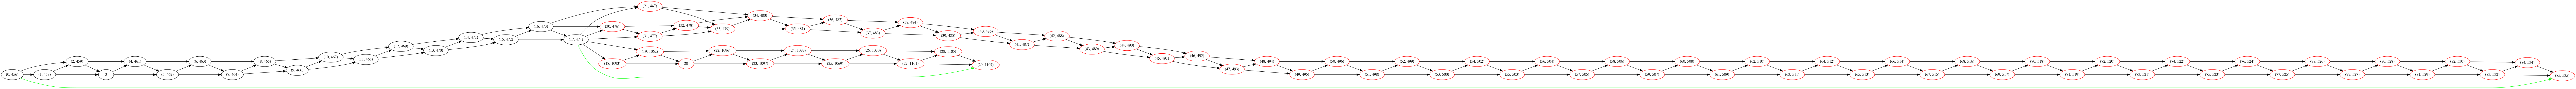

B 499
B 549
B 636
B 916
B 1071
B 1077
B 1078
B 1109
B 1115
B 1119
1 22
B 1119
4 29
B 1120
B 1122
2 23
B 1140
B 1141
B 1185
B 1188
B 1313
B 1403
B 1509
B 1512
B 1513
B 1516
B 1575
B 1627
B 1632
B 1681
1 34
B 1687
B 1694
B 1713
B 1796
B 1849
[2, 1] erg 2044 max 4898984 repeats 57 last 2080APD_0
T [2, 0]
2278APD_0


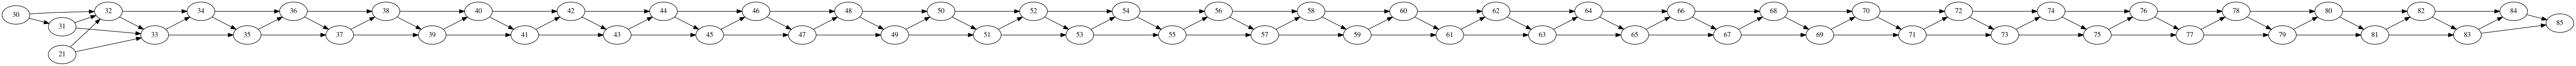

2278APD_0
447


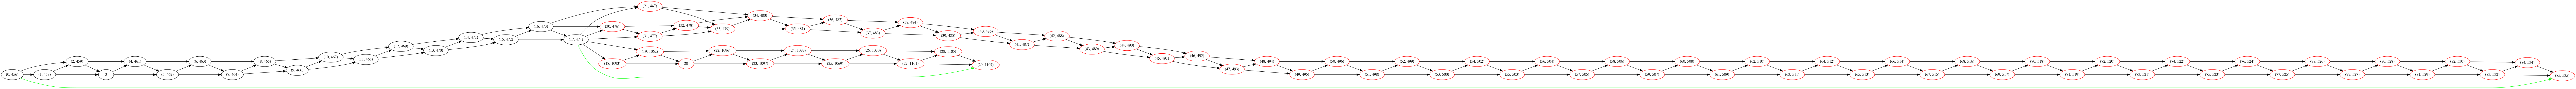

B 549
B 636
B 916
B 1071
B 1077
B 1078
B 1109
B 1115
B 1119
1 22
B 1119
4 29
B 1120
B 1122
2 23
B 1140
B 1141
B 1185
B 1188
B 1313
B 1403
B 1509
B 1512
B 1513
B 1516
B 1575
B 1627
B 1632
B 1681
1 34
B 1687
B 1694
B 1713
B 1796
B 1849
[2, 0] erg 2044 max 4898610 repeats 56 last 2080APD_0
T [1]
2324APD_0


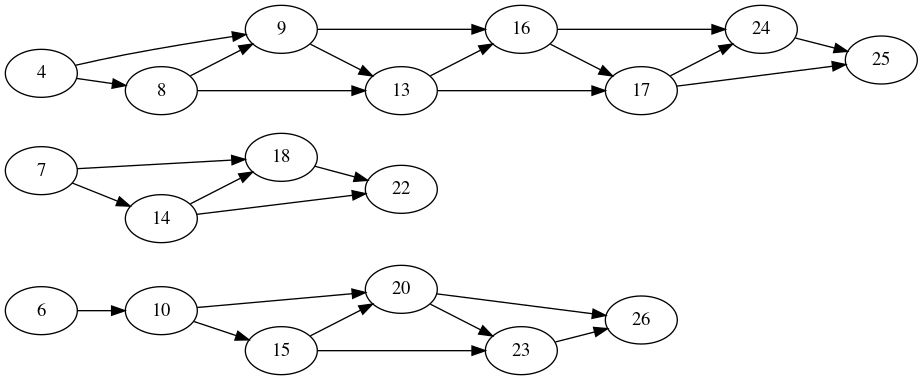

2324APD_0


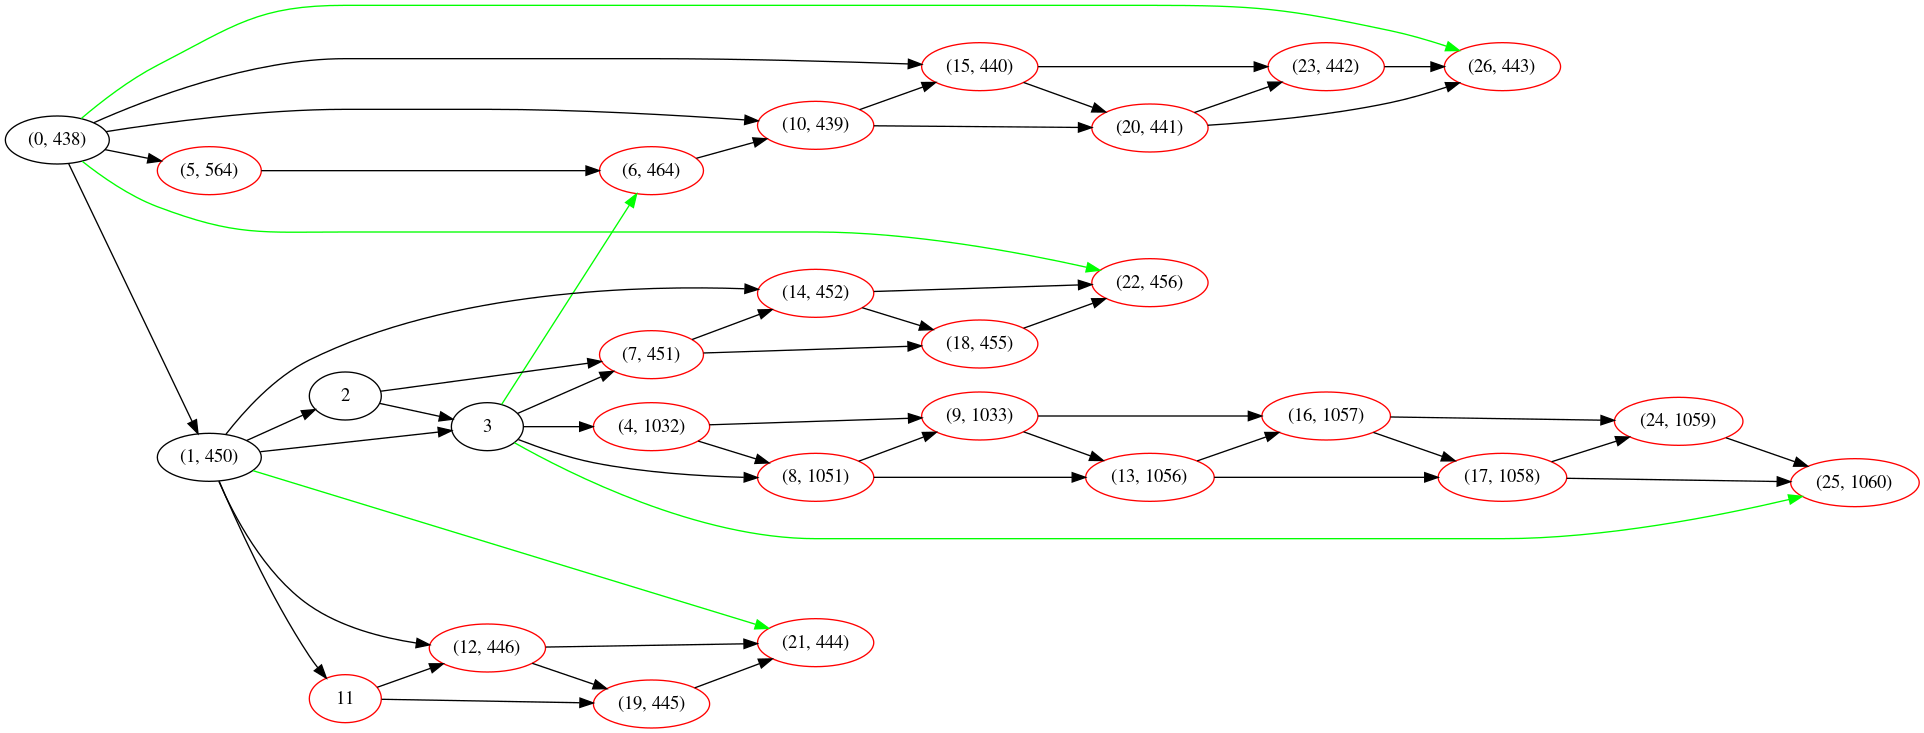

B 468
B 469
T [1, 1]
342APD_0


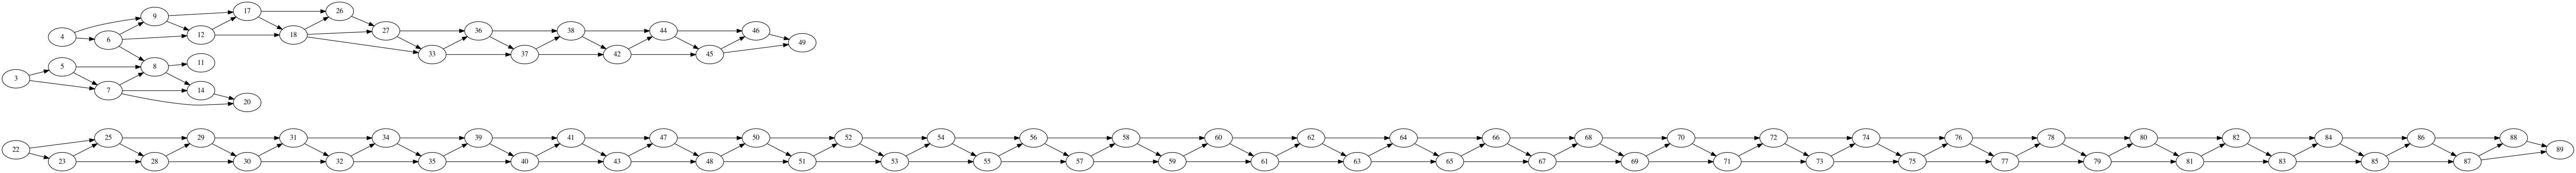

342APD_0
450
452
438
451


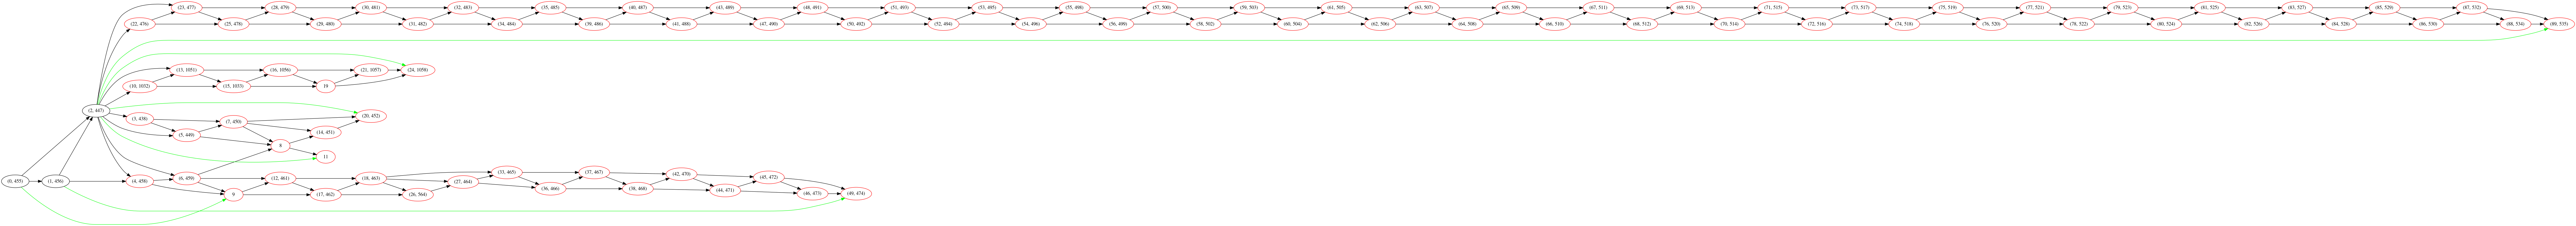

B 471
B 473
B 480
B 484
B 487
B 489
B 539
B 626
B 906
B 1061
B 1067
B 1068
B 1099
B 1105
B 1109
1 22
B 1109
4 29
B 1110
B 1112
2 23
B 1129
B 1132
B 1176
B 1179
B 1304
B 1394
B 1500
B 1503
B 1504
B 1507
B 1566
B 1618
B 1623
B 1672
1 34
B 1678
B 1685
B 1704
B 1787
B 1840
[1, 1] erg 2035 max 4844907 repeats 54 last 2080APD_0
T [1, 0]
342APD_0


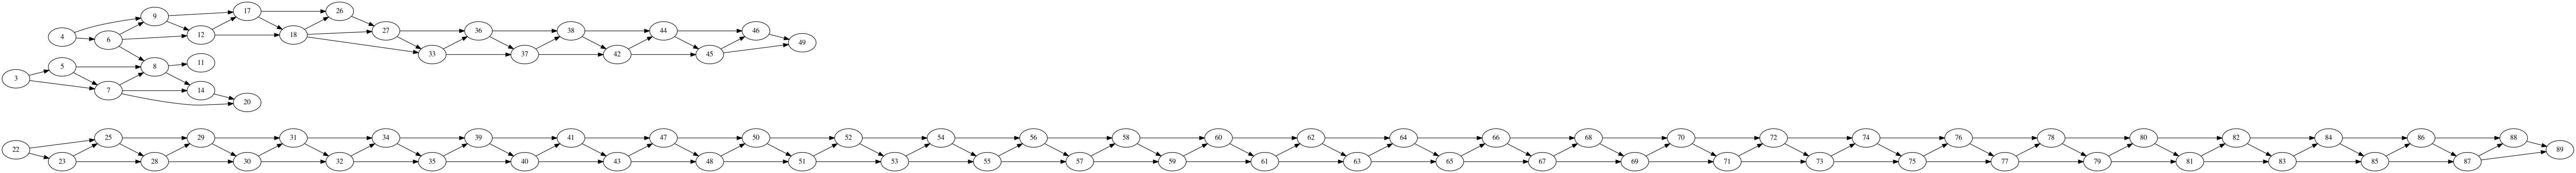

342APD_0
450
452
438
451


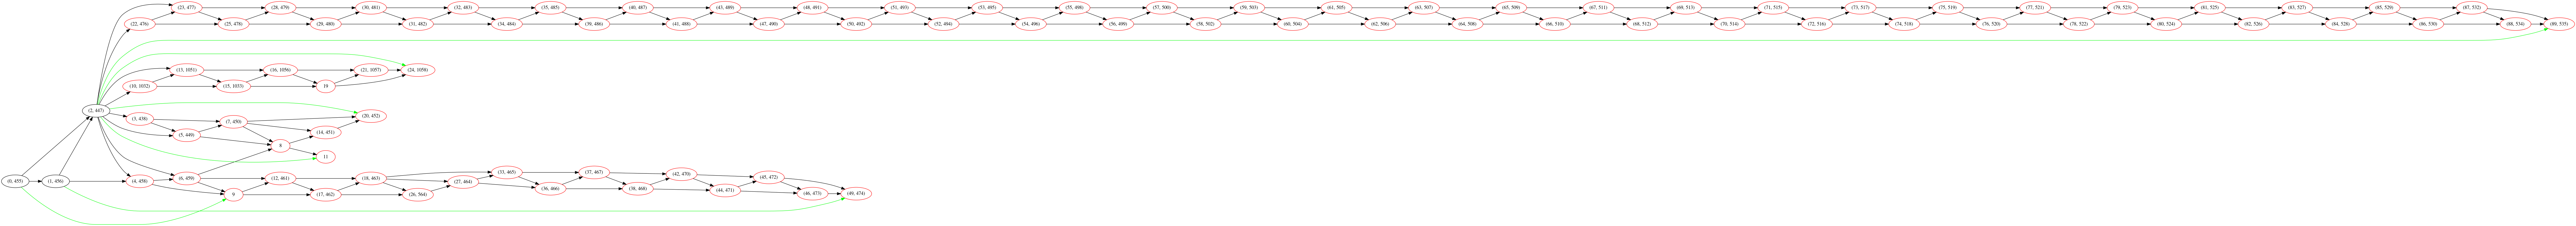

B 469
T [1, 0, 1]
501APD_0


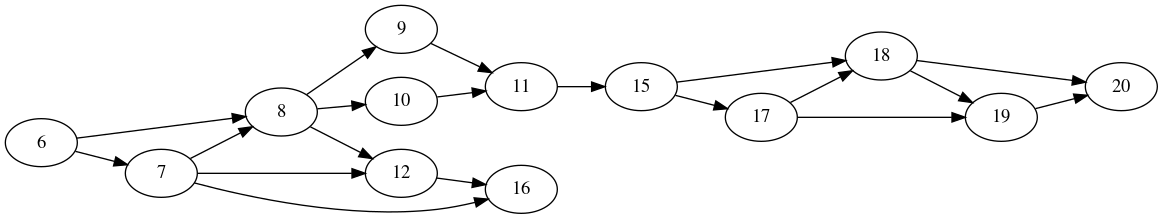

501APD_0
450
452
451


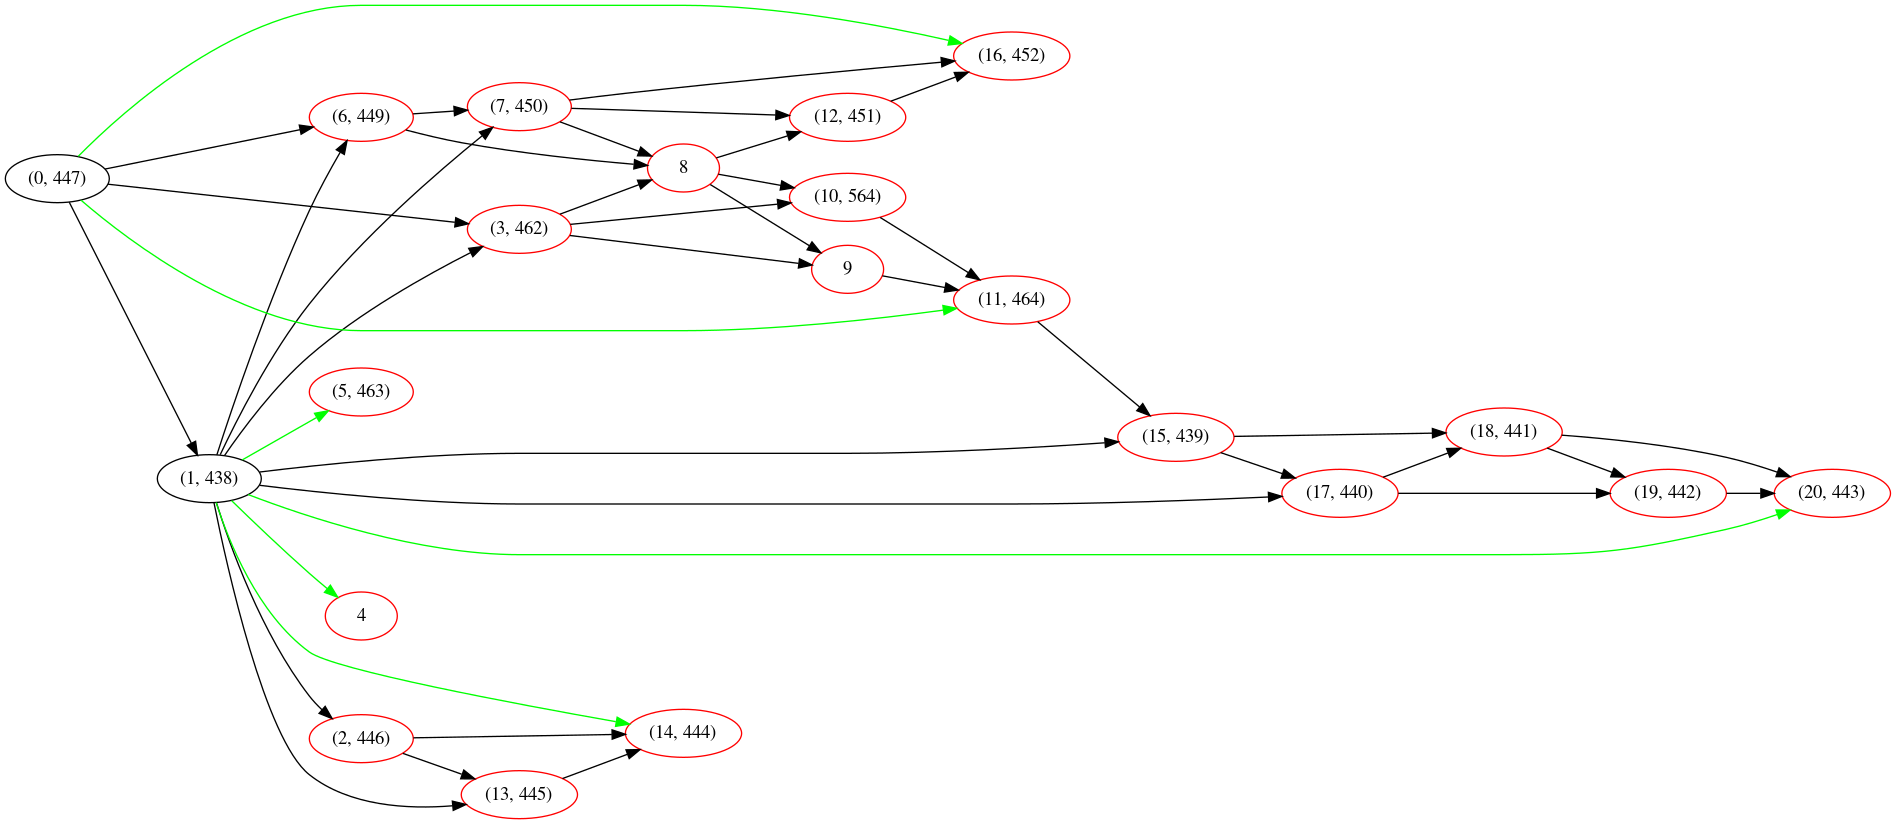

B 470
[1, 0, 1] erg 470 max 1359321 repeats 12 last 14APD_0
T [1, 0, 0]
501APD_0


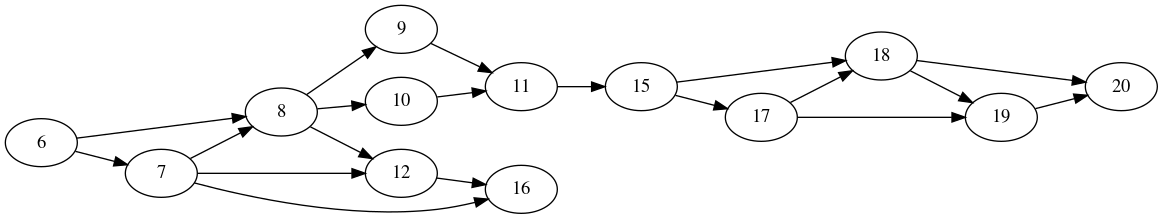

501APD_0
450
452
451


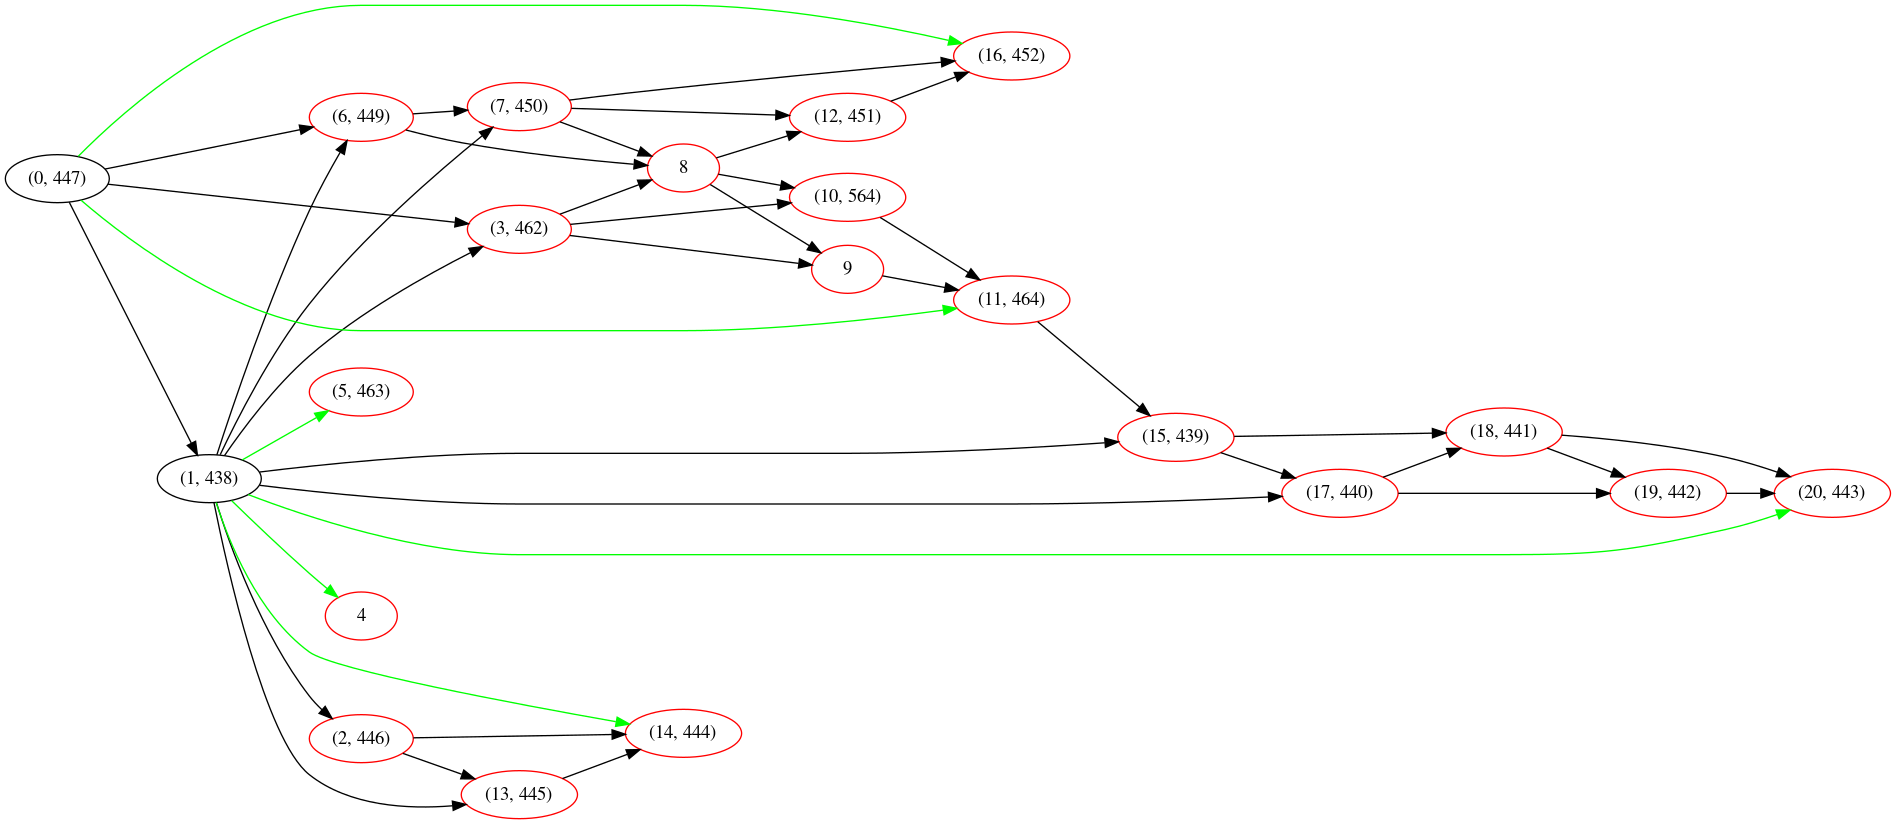

[1, 0, 0] erg 471 max 1357966 repeats 12 last 14APD_0
T [0]
2324APD_0


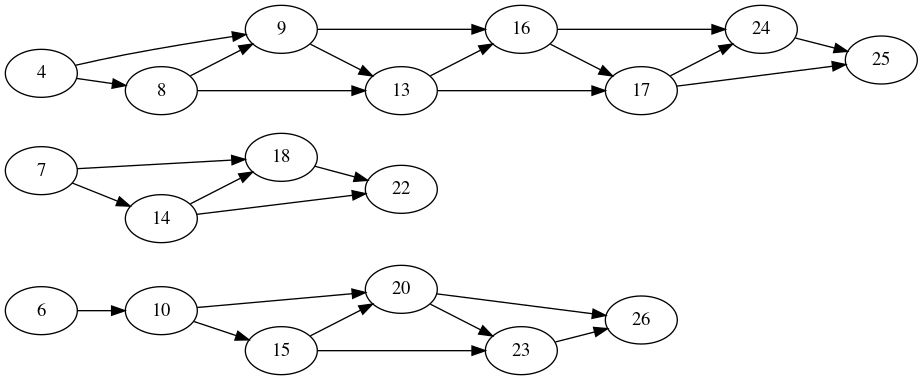

2324APD_0


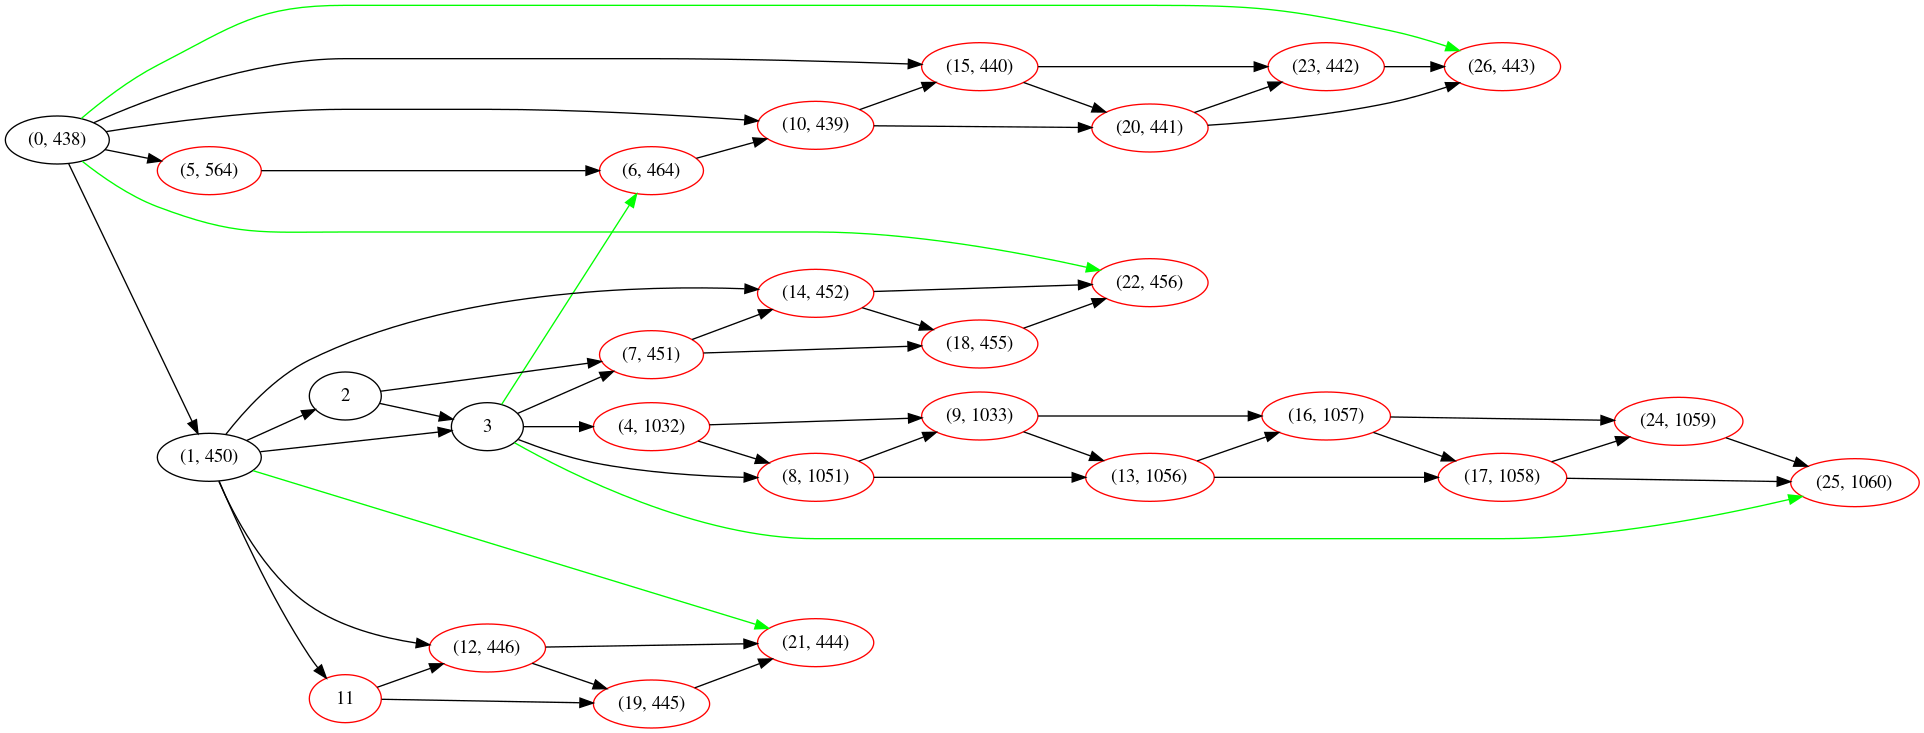

B 465
T [0, 1]
432APD_0


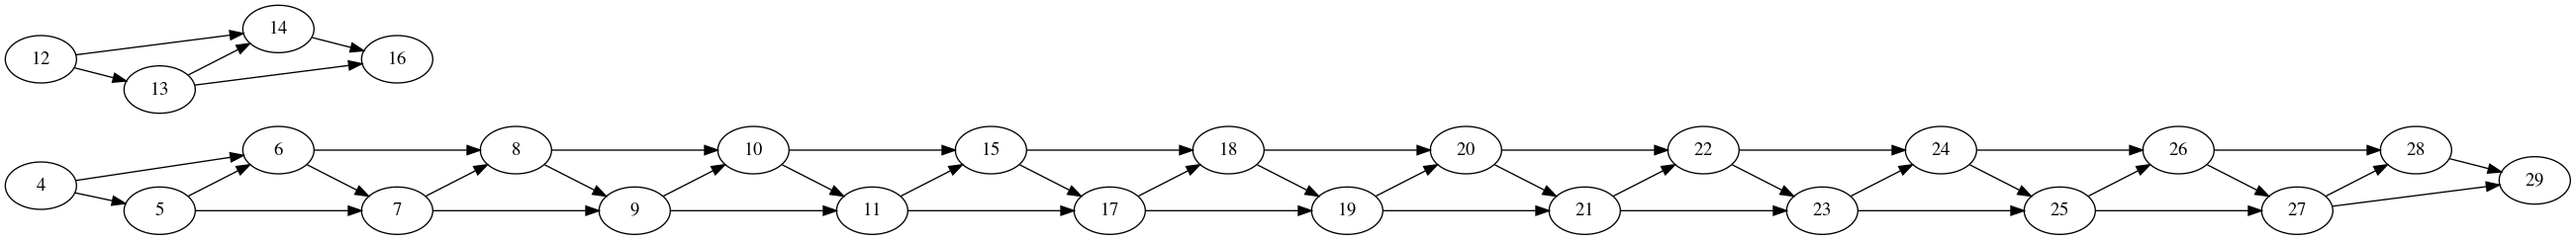

432APD_0


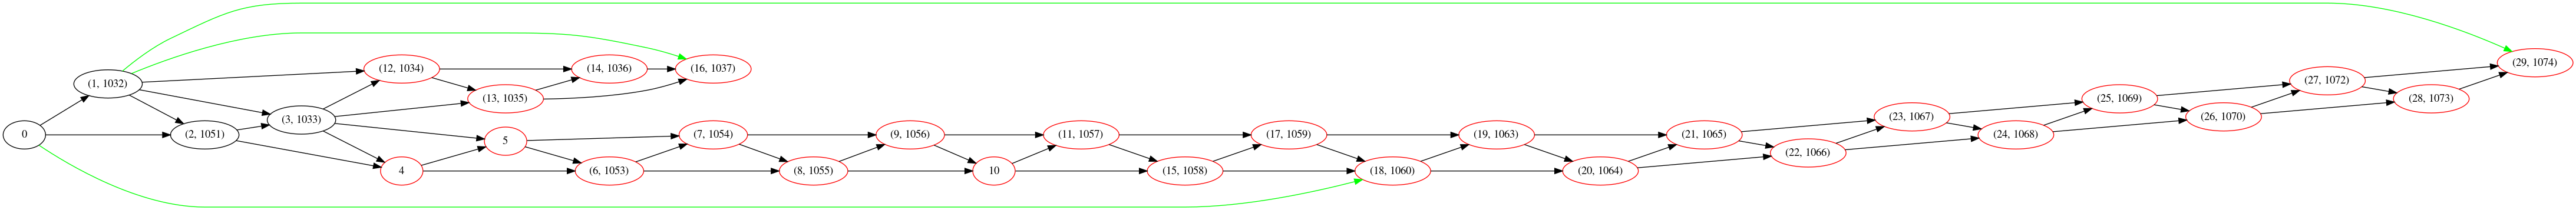

B 471
B 477
B 484
B 486
B 491
B 495
1 20
B 495
T [0, 1, 2]
1379APD_0


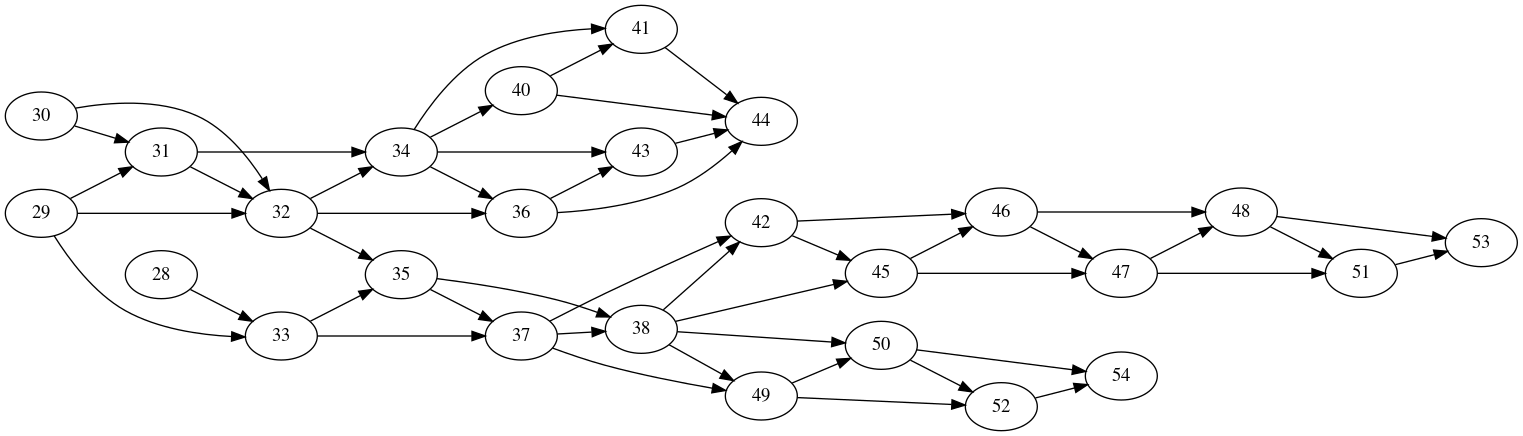

1379APD_0


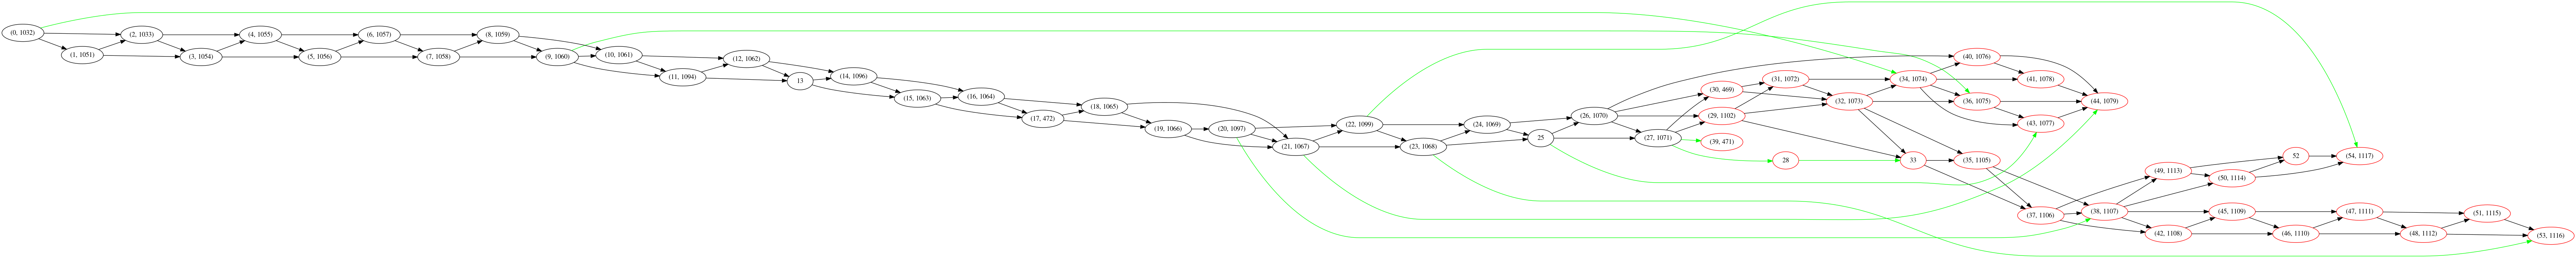

B 496
B 498
2 21
B 511
B 516
B 519
B 533
B 564
B 567
B 692
B 782
B 888
B 891
B 892
B 895
B 954
B 1006
B 1011
B 1060
1 34
B 1066
B 1073
B 1092
B 1175
B 1228
[0, 1, 2] erg 1423 max 3395711 repeats 41 last 2080APD_0
T [0, 1, 1]
1379APD_0


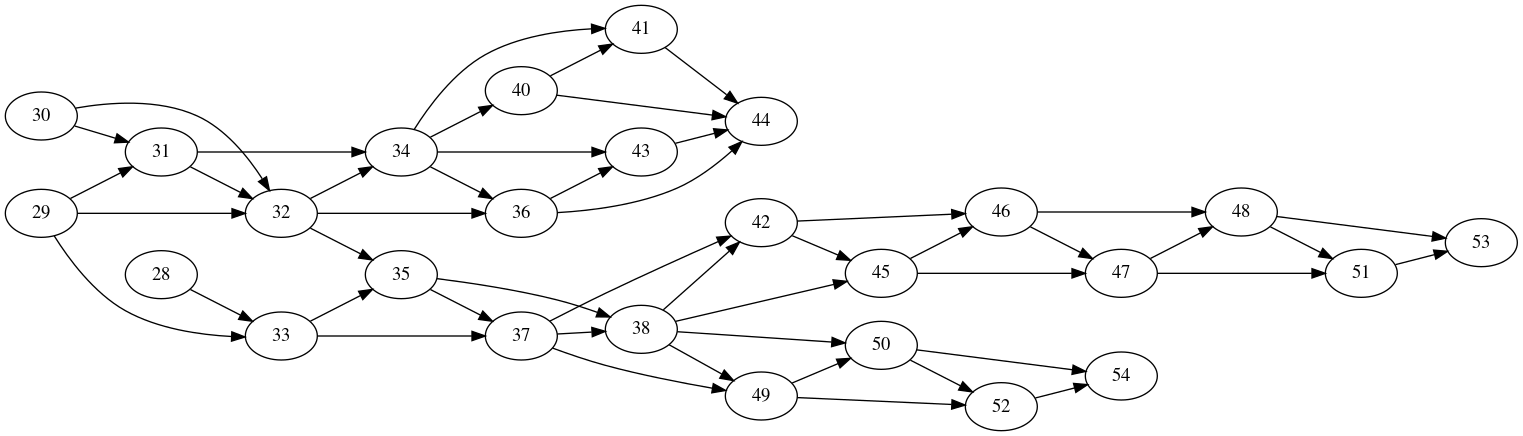

1379APD_0


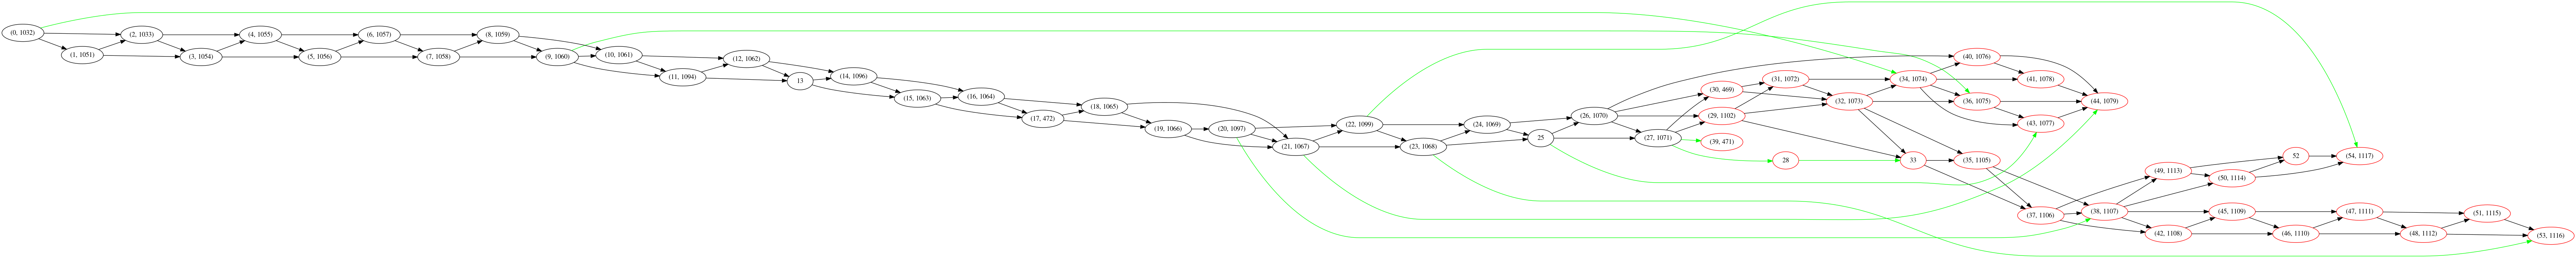

B 496
B 498
2 21
B 511
B 516
B 519
B 534
B 565
B 568
B 693
B 783
B 889
B 892
B 893
B 896
B 955
B 1007
B 1012
B 1061
1 34
B 1067
B 1074
B 1093
B 1176
B 1229
[0, 1, 1] erg 1424 max 3395710 repeats 40 last 2080APD_0
T [0, 1, 0]
1379APD_0


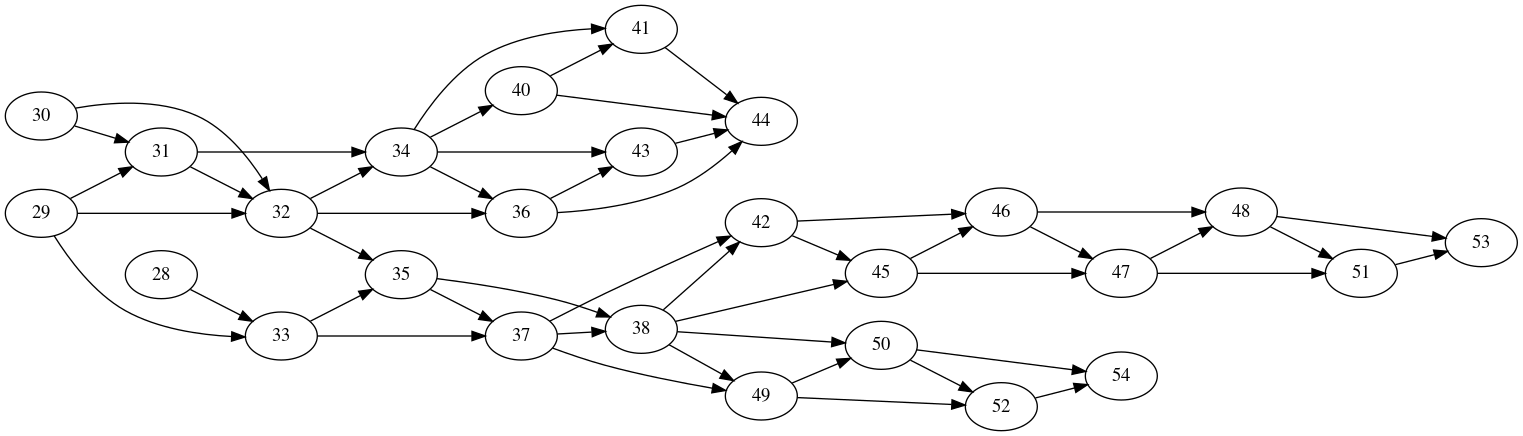

1379APD_0


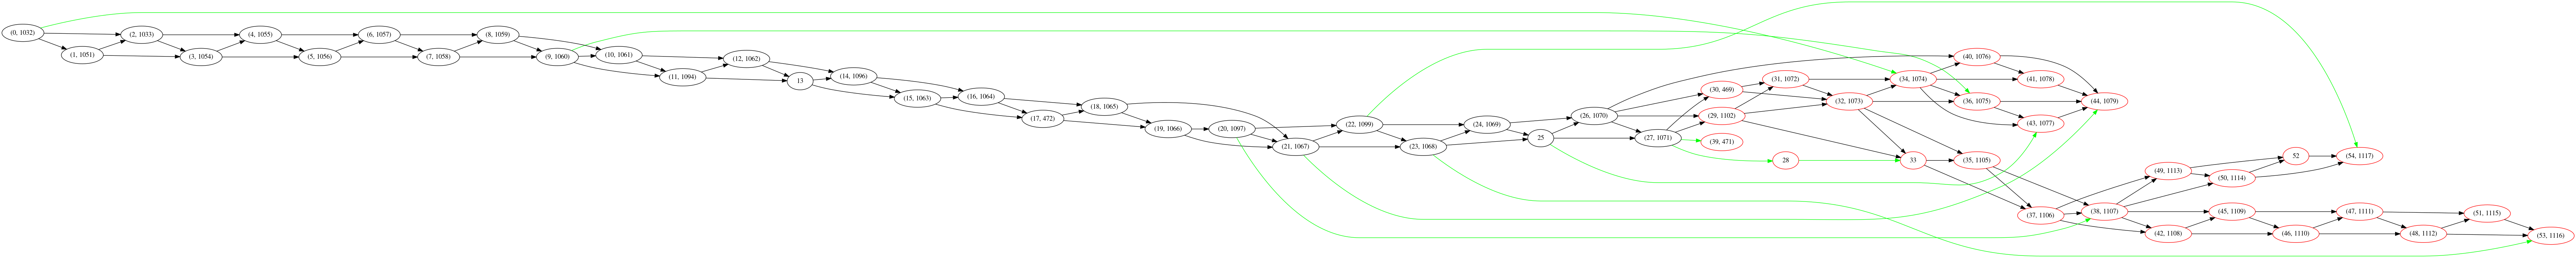

B 498
2 21
B 511
B 516
B 518
B 518
B 519
B 533
B 564
B 567
B 692
B 782
B 888
B 891
B 892
B 895
B 954
B 1006
B 1011
B 1060
1 34
B 1066
B 1073
B 1092
B 1175
B 1228
[0, 1, 0] erg 1423 max 3396034 repeats 41 last 2080APD_0
T [0, 0]
432APD_0


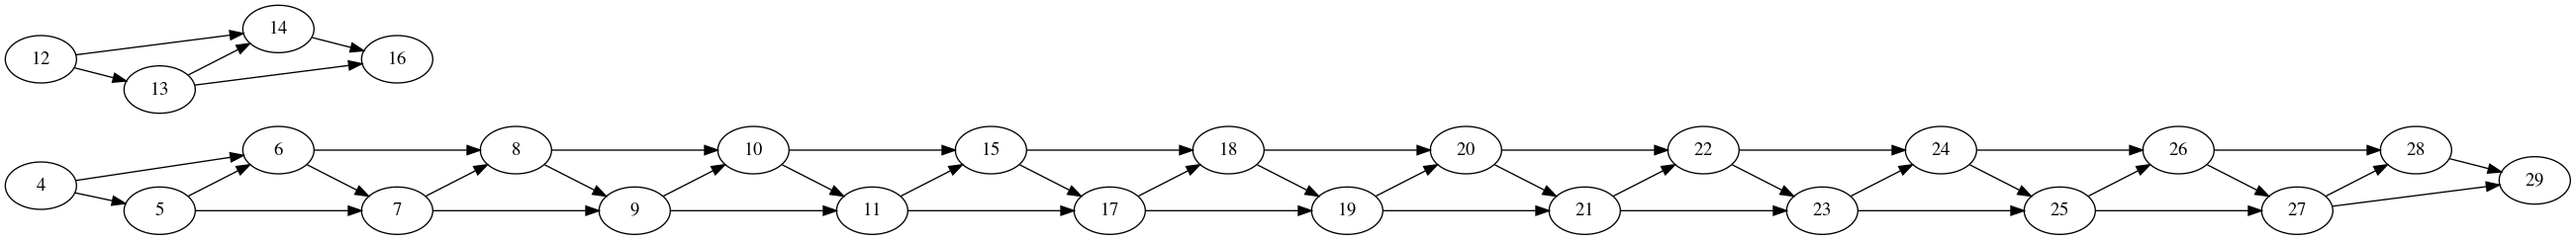

432APD_0


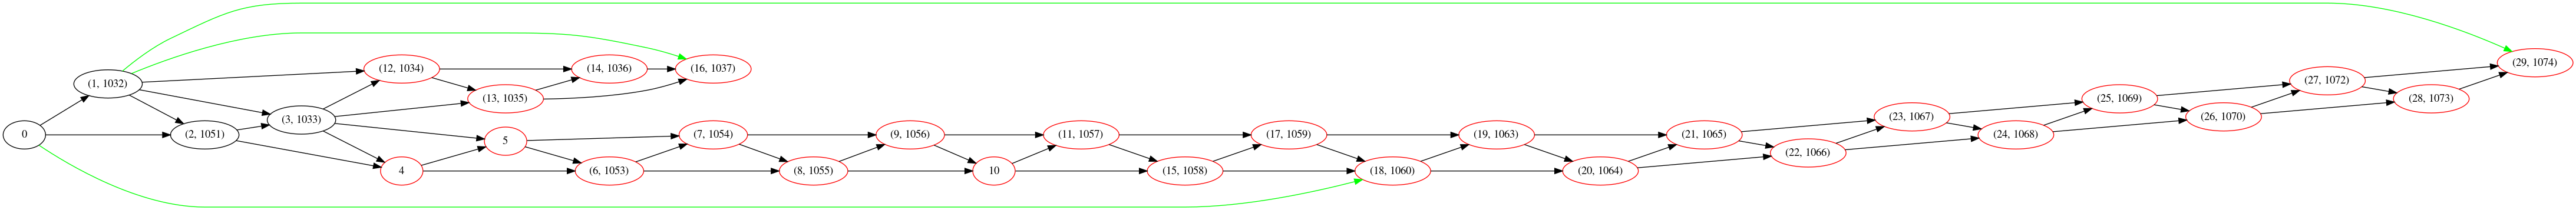

B 466
B 479
B 485
B 503
B 505
B 510
B 514
1 23
B 514
T [0, 0, 2]
1379APD_0


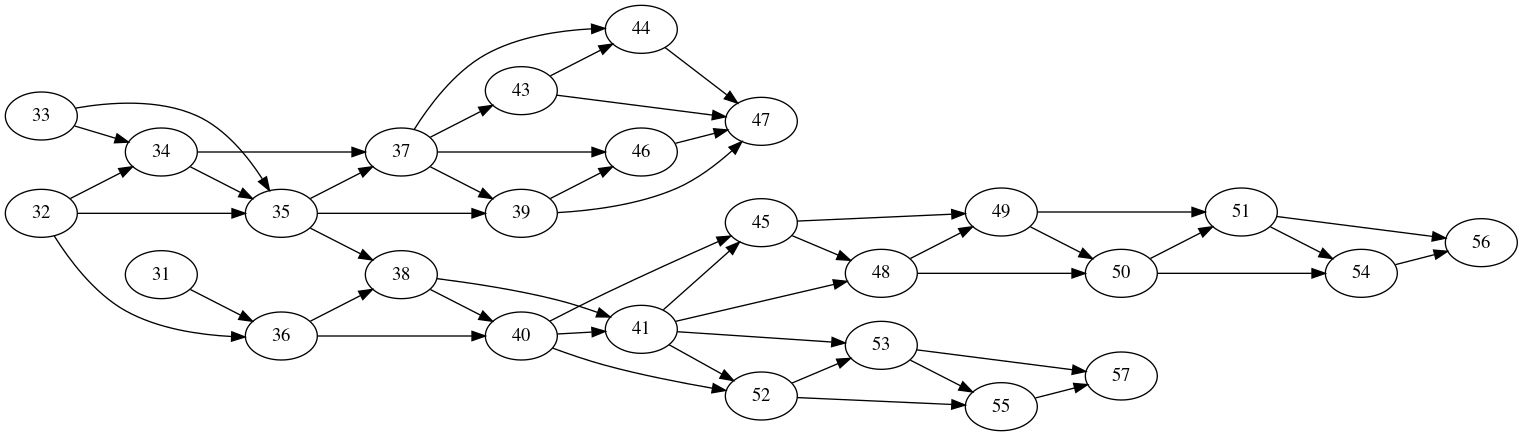

1379APD_0


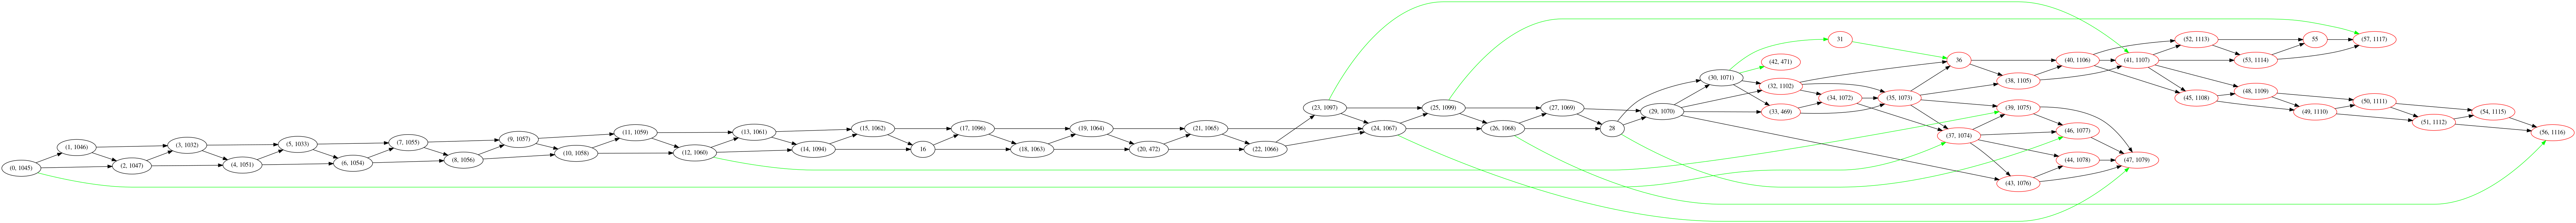

B 515
B 517
2 24
B 530
B 535
B 538
B 552
B 583
B 586
B 711
B 801
B 907
B 910
B 911
B 914
B 973
B 1025
B 1030
B 1079
1 34
B 1085
B 1092
B 1111
B 1194
B 1247
[0, 0, 2] erg 1442 max 3470147 repeats 45 last 2080APD_0
T [0, 0, 1]
1379APD_0


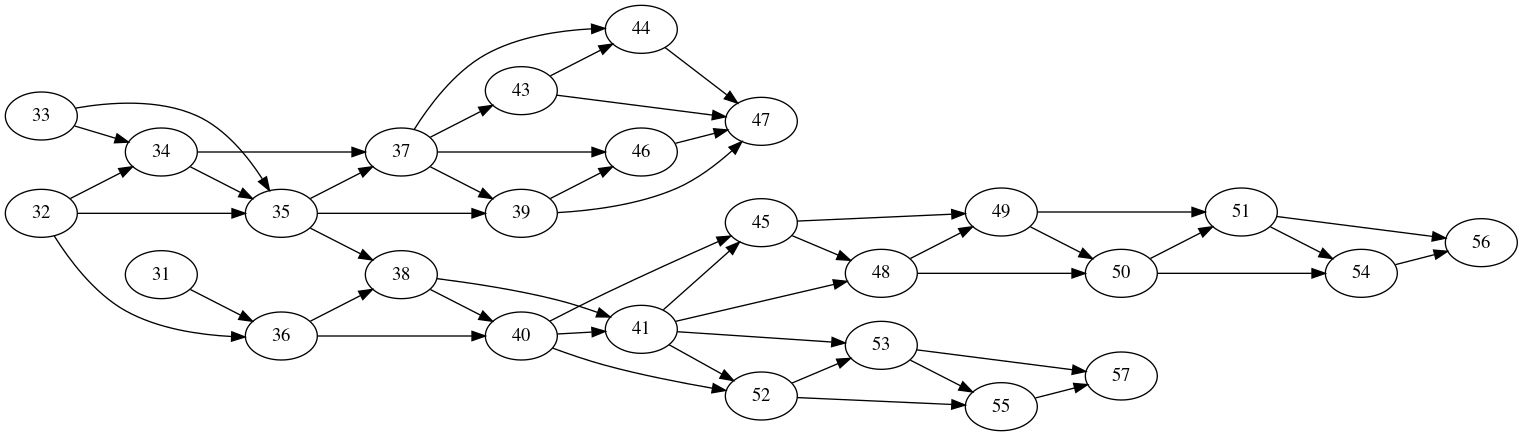

1379APD_0


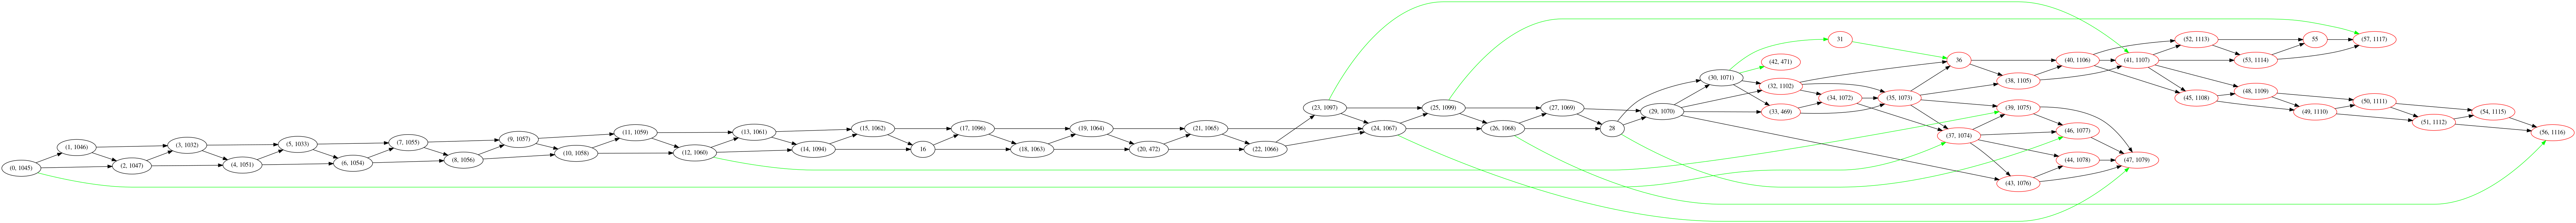

B 515
B 517
2 24
B 530
B 535
B 538
B 553
B 584
B 587
B 712
B 802
B 908
B 911
B 912
B 915
B 974
B 1026
B 1031
B 1080
1 34
B 1086
B 1093
B 1112
B 1195
B 1248
[0, 0, 1] erg 1443 max 3470146 repeats 44 last 2080APD_0
T [0, 0, 0]
1379APD_0


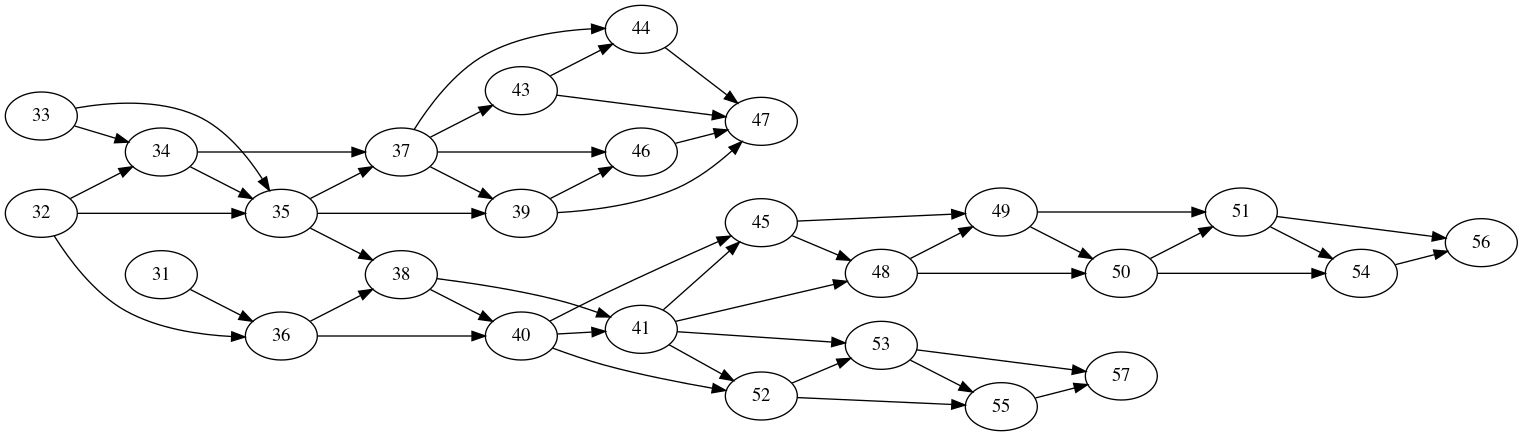

1379APD_0


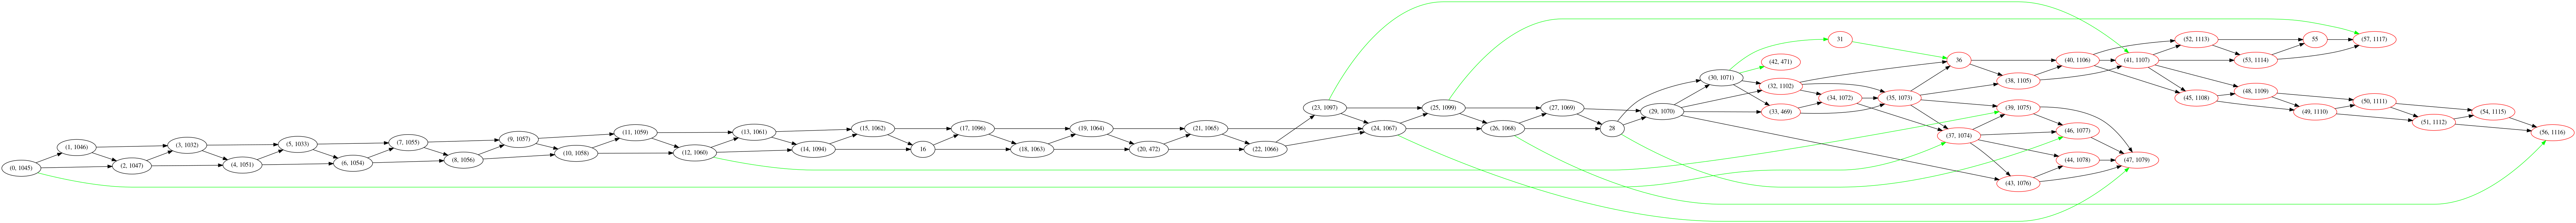

B 517
2 24
B 530
B 535
B 537
B 537
B 538
B 552
B 583
B 586
B 711
B 801
B 907
B 910
B 911
B 914
B 973
B 1025
B 1030
B 1079
1 34
B 1085
B 1092
B 1111
B 1194
B 1247
[0, 0, 0] erg 1442 max 3470471 repeats 45 last 2080APD_0


In [39]:
"""
graph = nx.MultiDiGraph() 
for a, b, d in data2:
    if a != b:
        graph.add_edge(b,a,d)
entferne_sackgassen(graph,start='2080APD_0',ziel='2345APD_0')
graph2 = nx.MultiDiGraph() 
for d, a, b, g in data3:
    if a != b:
        graph2.add_edge(b,a,d,gewicht = g)
entferne_sackgassen(graph2,start='2080APD_0',ziel='2345APD_0')
'''
evil = singels(graph)
graph.remove_nodes_from(evil)
graph2.remove_nodes_from(evil)
evil = überdeckte(graph2)
graph.remove_nodes_from(evil)
graph2.remove_nodes_from(evil)
'''
aktuell = '2080APD_0'
position = {}
pre_position = {'2080APD_0' : 0}
constr_pos = coll.defaultdict(list)
constr_pos[aktuell] = [0]
#besucht = []

"""









start = '2345APD_0'
ziel = '2080APD_0'
graph = nx.MultiDiGraph() 
for a, b, d in data2:
    if a != b:
        graph.add_edge(a,b,d)
print(len(graph.edges()))
#entferne_sackgassen(graph, start = start, ziel = ziel)
graph2 = nx.MultiDiGraph() 
for d, a, b, g in data3:
    if a != b:
        graph2.add_edge(a,b,d, gewicht = g)
        
        
g3 = nx.MultiDiGraph() 
for d, a, b, g in data3:
    if g > 2:
        g3.add_edge(a,b,d)
#entferne_sackgassen(graph2, start = start, ziel = ziel)

#evil = singels(graph)
#graph.remove_nodes_from(evil)
#graph2.remove_nodes_from(evil)
print(len(graph2.edges()))


#evil = überdeckte(graph2)
#graph.remove_nodes_from(evil)
#graph2.remove_nodes_from(evil)

aktuell = start
position = {}
pre_position = {aktuell : 0}
constr_pos = coll.defaultdict(list)
constr_pos[aktuell] = [0]
#besucht = []
def gruppiert2(werte, min_abstand):
    sorted_werte = sorted(werte) 
    
    previous = sorted_werte[0]
    current_group = []
    max_len = 0
    for current in sorted_werte:
        if current - previous > min_abstand:
            
            this_len = len(current_group)
            if this_len > max_len:
                max_group = current_group[this_len//2]
                max_len = this_len
                
            current_group = []
            
        current_group.append(current)
        previous = current
        
    this_len = len(current_group)
    if this_len > max_len:
        max_group = current_group[this_len//2]
        max_len = this_len
        
    return max_group

def aa(constr_pos):
    return min(
        (gruppiert2(constr_pos[contig], 500),contig) 
        for contig in constr_pos 
    )

        
                    
###############################################################
def bb (graph,_, position, constr_pos, aktuell, pos):
    for a,b,d in graph.out_edges(aktuell, keys = True):
        constr_pos[b].append(pos + d)
        

def bb (graph,position,constr_pos,aktuell,pos):
    for contig, dists in graph.succ[aktuell].items():
        for dist in dists:
            if not contig in position or (not aktuell in position and pos + dist - position[contig] > 200000):
                constr_pos[contig].append(pos + dist)
                
def bb (graph,graph2,position,constr_pos,aktuell,pos):
    for contig, dists in graph.succ[aktuell].items():
        for dist in dists:
            if not contig in position:
                constr_pos[contig].append(pos + dist)
            elif not aktuell in position and contig in graph2[aktuell]:
                d = min(list(graph2[aktuell][contig]), key = lambda d: abs(d-dist))
                g = graph2[aktuell][contig][d]['gewicht']
                if g>2 and pos + dist - position[contig] > 20000:
                    constr_pos[contig].append(pos + dist)
            
def cc(constr_pos):
    return {
        contig: gruppiert2(constr_pos[contig], 500)
        for contig in constr_pos 
    }

def dd2(graph, pre_position):
    subgraph = nx.DiGraph()
    nahe = sorted(pre_position.items(),key = lambda x: x[1])[:7]
    nahe = {k for k,_ in nahe}
    subgraph.add_nodes_from(nahe)
    subgraph.add_edges_from({
            (a,b) 
            for a in nahe
            for b, l in graph.succ[a].items() if b in nahe and pre_position[b] > pre_position[a] 
            for d in l if abs(pre_position[b] - pre_position[a] - d) < 5000
        }
    )
    return subgraph

def dd3(graph, pre_position):
    subgraph = nx.DiGraph()
    subgraph.add_nodes_from(pre_position)
    subgraph.add_edges_from({
            (a,b) 
            for a, pa in pre_position.items()
            for b, l in graph.succ[a].items() if b in pre_position and pre_position[b] > pa
            for d in l if -400 - 0.005*d <= pre_position[b] - pa - d <= 400  + 0.005*d #-500 <= pre_position[b] - pa - d <= 500         
        }
    )
    return subgraph

def solve(graph, graph2, position, constr_pos, rr = [], i=[], repeats = [], aktuell = '', old = 0):
 #   if len(rr)>3:
  #      return
    while constr_pos:
     #   aktuell, pos = min(pre_position.items(),key = lambda x: x[1])
       ###  if aktuell in intNameX:
        ###     old = min((intNameX[x] for x in rep[aktuell[:-2]]), key = lambda x: abs(x-old))
        pos, aktuell = aa(constr_pos)
        
        ### if aktuell in intNameX:
        ###     new = min((intNameX[x] for x in rep[aktuell[:-2]]), key = lambda x: abs(x-old))
        ###     if 4 <= abs(new - old):
        ###         print('H',old,new)
      #  print(int(pos), aktuell)
        """for p in constr_pos[aktuell].copy():
            if p < 30000 + pos:
                constr_pos[aktuell].remove(p)
                
        if not constr_pos[aktuell]:
            constr_pos.pop(aktuell)"""
        """  else:graph, graph2, position, constr_pos, rr = [], i=[], repeats = [], aktuell = '', old = 0
            print(aktuell)
            for p in constr_pos[aktuell].copy():
                print(p-pos)"""
        constr_pos.pop(aktuell)
        
        h = True
        for a,b,d,g in graph2.in_edges(aktuell,keys = True, data = 'gewicht'):
            if not a in position or g == 1:
                continue
            if -500 <= pos - position[a] - d <= 500:
                h = False
                break
        if h and aktuell != '2345APD_0':
            continue
            
        iii = 0
        for c in constr_pos.copy():
            for p in constr_pos[c].copy():
                if p < pos:
                    iii+=1
                    constr_pos[c].remove(p)
                if not constr_pos[c]:
                    print('J', c)
                    constr_pos.pop(c)
     #   if iii > 10:
      #      print('w', iii, len(position))
        # aktualisiere constr_pos
        bb(graph, graph2, position, constr_pos, aktuell, pos)
        
        if aktuell in position:
            repeats = repeats + [(aktuell, position[aktuell])]
        position[aktuell] = pos

        
        pre_position = cc(constr_pos)
        subgraph2 = dd3(graph, pre_position)
        g0 = {a for a in subgraph2 if subgraph2.in_degree[a] == 0}
        
        """
        grad0 = {
            b 
            for b in grad0 if b in graph[aktuell]
            for d in graph[aktuell][b] if abs(pre_position[b] - position[aktuell] - d) < 2000
        }"""
        grad0 = set()
        while g0:
            s = g0.pop()
            h = True
            for a,b,d,g in graph2.in_edges(s,keys = True, data = 'gewicht'):
                
                if not a in position or g == 1:
                    continue
                if -500 <= pre_position[b] - position[a] - d <= 500:
                    h = False
                    break
            if h:
                N = list(subgraph2[s])
                subgraph2.remove_node(s)
              #  pre_position.pop(s)
               # constr_pos.pop(s)
                for c in N:
                    if subgraph2.in_degree[c] == 0:
                        g0.add(c)
            else:
                grad0.add(s)
                

        if len(grad0) > 1:
            print('B',len(position))
            hl = len(grad0)
            grad0 = {
                b 
                for b in grad0 if b in graph[aktuell]
                for d in graph[aktuell][b] if abs(pre_position[b] - position[aktuell] - d) < 500
            }
            if len(grad0) == 0:
                print('kein geeigneter Nachfolger gefunden.')
                
            
                
            rr.append(aktuell)
          ##  print('-',aktuell)
            komponenten = [set(nx.predecessor(subgraph2, start)) for start in grad0]
            
            count_nodes = sum((coll.Counter(kompon) for kompon in komponenten), coll.Counter())
            komponenten_2 = [{a for a in kompon if count_nodes[a] == 1} for kompon in komponenten]
            mini_k = [(g0,k) for g0, k, k2 in zip(grad0, komponenten, komponenten_2) if len(k2) == 1]
            evil = set()
            for (sa,ka), (sb,kb) in it.combinations(mini_k,2):
                if len(ka) > 1 and ka-{sa} == kb-{sb}:
                    sa_repeat = sa in position 
                    sb_repeat = sb in position 
                    h = False
                    if sa_repeat and not sb_repeat:
                        h = sa
                        evil.add(sa)
                     #   print(1111111111111)
                        continue
                    if sb_repeat and not sa_repeat:
                        h = sb
                        evil.add(sb)
                   #     print(2222222222222)
                        continue
                    preds_a = { a
                                for a,l in graph2.pred[sa].items() if a in position
                                for d in l if abs(pre_position[sa] - position[a] - d) < 500 }
                    preds_b = { a
                                for a,l in graph2.pred[sb].items() if a in position
                                for d in l if abs(pre_position[sb] - position[a] - d) < 500 }
                    if len(preds_a) > len(preds_b):
                        evil.add(sb)
                    else:
                        evil.add(sa)
                        
            if len(evil)>0:
                grad0 -= evil
                komponenten = [set(nx.predecessor(subgraph2, start)) for start in grad0]
                count_nodes = sum((coll.Counter(kompon) for kompon in komponenten), coll.Counter())
                komponenten = [{a for a in kompon if count_nodes[a] == 1} for kompon in komponenten]
                
                
            else:
                komponenten = komponenten_2
            """
            for komponente in komponenten:
                for b in komponente:
                    for a,l in graph2.pred[b].items():
                        if a in position:
                            for d in l: 
                                if abs(pre_position[b] - position[a] - d) < 2000:
                                    (a,b,d)
            """
            
            komponenten = [
                (
                    {
                        a
                        for b in komponente
                        for a,l in graph2.pred[b].items() if a in position
                        for d in l if abs(pre_position[b] - position[a] - d) < 2000
                    }, 
                    komponente)#,
             #   ([
             #       (a,b,d)
             #       for b in komponente
             #       for a,l in graph.pred[b].items() if not a in position
             #       for d in l
             #   ], komponente)
                for komponente in komponenten
            ]
           # for preds, komponente in komponenten:
            #            ({
           #                 (a,b,d)
           #                 for b in komponente
           #                 for a,l in graph.pred[b].items() if a in position
           #                 for d in l if abs(pre_position[b] - position[a] - d) < 2000
           #             }, komponente)
            s = komponenten[0][0].copy()
            for pro, _ in komponenten[1:]:
                s &= pro
            try:
                min_s = min(position[x] for x in s)
            except:
                print('kein Schnitt')
                min_s = 10000000
              
            komponenten = [[{p for p in pro if position[p] < min_s}, k] for pro, k in komponenten]
            komponenten = sorted([[len(pro),sorted([position[x] for x in pro]),k] for pro, k in komponenten],reverse=True)
            
            kk = [min(k,key = lambda x: pre_position[x]) for _,_,k in komponenten]
            G = graph.subgraph(set(graph)-set(position))
            if len(komponenten) > 1 and not komponenten[1][0]*5+2 <= komponenten[0][0]:
                for (a,ka), (b,kb) in it.combinations(zip(kk,komponenten),2):
                    if ka in komponenten and kb in komponenten:
                        if a not in G or b not in G:
                            continue
                        ab = nx.has_path(G,a,b)
                        ba = nx.has_path(G,b,a)
                        if a in position and not b in position:
                            komponenten.remove(ka)
                        elif not a in position and b in position:
                            komponenten.remove(kb)
                        elif ab and not ba:
                            komponenten.remove(kb)
                        elif ba and not ab:
                            komponenten.remove(ka)
            if len(komponenten) > 1 and komponenten[1][0] != 0 and komponenten[1][0]*5+2 <= komponenten[0][0]:
                print(komponenten[1][0],komponenten[0][0])
                
                
            if len(komponenten) == 1 or (komponenten[1][0]*5+2 <= komponenten[0][0]):
                
              #  print('U',len(position),aktuell)#,intName[aktuell])
                
                komponente = komponenten[0][2]
                
                ##print(aktuell)
                ##p = position.copy()
                ##pp = pre_position.copy()
                ##p.update(pp)
                ##A = {i for a,b,d in data2 if a in p and b in pp and -2000 < p[b] - p[a] -d < 2000 for i in [a,b] }
                ##plot_graph(p,[[a,b,d] for a,b,d in data2 if a in A and b in A],X = set(pp), bis = 3000,fehler = 1000)
                
                pos, start = aa(constr_pos_komp)
                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k] for k in  set(nx.predecessor(subgraph2, start))})
                
                iii = 0
                for c in constr_pos_komp.copy():
                    if c == start:
                        continue
                    for p in constr_pos_komp[c].copy():
                        if p < pos:
                            iii+=1
                            constr_pos_komp[c].remove(p)
                        if not constr_pos_komp[c]:
                            print('J', c)
                            constr_pos_komp.pop(c)
             #   if iii > 0:
              #      print('i', iii, len(position))
              ###   intName = get_intName(p)
              ###  for x in sorted(constr_pos_komp, key = lambda x: constr_pos_komp[x][0])[:3]:
              ###      print(intName[x])
                return solve(graph,graph2,position,constr_pos_komp,rr,i,repeats,aktuell,old)
            
            """print('s', s)
            print('anz', len(komponenten))
            print(komponenten[0][0],komponenten[1][0])
            print(komponenten[0][1][:2],komponenten[1][1][:2])
            print(len(komponenten[0][2]),len(komponenten[1][2]))
            print()"""
            erg = []
            index = len(i)
            i.append(len(komponenten))
            for _,_, komponente in komponenten:
                i = i[:index+1]
                i[index] -= 1
                print('T',i,)#intName[aktuell])
                print(aktuell)
                p = position.copy()
                pp = pre_position.copy()
                p.update(pp)
                A2 = {i for a,b,d in data2 if a in p and b in pp and -500 < p[b] - p[a] -d < 500 for i in [a,b] }
                p = {x:v for x,v in p.items() if x in A2}


                A = set()
                L = set()
                E = set()

                DD = set()
                for a,b,d,g in graph2.edges(keys = True, data = 'gewicht'):
                    if not {a,b} <= A2 or not -500 < p[b] - p[a] - d < 500:
                        continue
                    E.add((a,b,d,g))
                    for c in set(graph2.successors(a)) & set(graph2.predecessors(b)):
                        if not c in A2:
                            DD.add(c)
                            continue
                        for (d1, g1), (d2, g2) in it.product(graph2[a][c].items(),graph2[c][b].items()):
                            if not -500 < p[c] - p[a] - d1 < 500 or not -500 < p[b] - p[c] - d2 < 500:
                                continue
                            g1 = g1['gewicht']
                            g2 = g2['gewicht']
                            if -1000 <= d1 + d2 - d <= 1000 and d1 <= d and d2 <= d:
                                if g == 1 or (g1 > 1 and g2 > 1):# g <= g1 and g <= g2:
                                    L.add((a,b,d,g))
                                A.add((a,c,d1,g1))
                                A.add((c,b,d2,g2))

                graph3 = nx.DiGraph()
                for a in pp:
                    """if a in intNameX:
                        a = intNameX[a]"""
                    graph3.add_node(a, color = 'red')

                for a,b,d,g in (E-L)-(E-A):
                    """if a in intNameX:
                        a = intNameX[a]
                    if b in intNameX:
                        b = intNameX[b]"""
                    graph3.add_edge(a,b,label = '%d,  %d'%(d//100,g))

                for a,b,d,g in (E-A)-(E-L):
                    """if a in intNameX:
                        a = intNameX[a]
                    if b in intNameX:
                        b = intNameX[b]"""
                    graph3.add_edge(a,b,label = '%d,  %d'%(d//100,g),color = 'green')

                for a,b,d,g in (E-L)&(E-A):
                    """if a in intNameX:
                        a = intNameX[a]
                    if b in intNameX:
                        b = intNameX[b]"""
                    graph3.add_edge(a,b,label = '%d,  %d'%(d//100,g), color = 'red')
                subgraph = nx.DiGraph()
                intName = get_intName(p)
                for a in subgraph2:
                    E1 = sorted([(a,b) for a,b in subgraph2.in_edges(a)], key = lambda x: p[x[0]],reverse = True)[:2]
                    E1+= sorted([(a,b) for a,b in subgraph2.out_edges(a)], key = lambda x: p[x[1]])[:2]
                    for a,b in E1:
                        subgraph.add_edge(intName[a],intName[b])
                pydot = nx.nx_pydot.to_pydot(subgraph)
                pydot.set_rankdir('LR')

                pydot.write_png('t.png')
                display(Image(filename='t.png'))
                print(aktuell)
                for p in pre_position:
                    if p in position:
                        if p in intNameX:
                            print(intNameX[p])
                        else:
                            print(p)

                p = position.copy()
                pp = pre_position.copy()
                p.update(pp)
                A2 = {i for a,b,d in data2 if a in p and b in pp and -500 < p[b] - p[a] -d < 500 for i in [a,b] }
                p = {x:v for x,v in p.items() if x in A2}
              #  for c in grad0:
                  #  print(c,pre_position[c])
                plot_graph(p,[[a,b,d] for a,b,d in data2 if a in A2 and b in A2],X = set(pp),E = (E-A),kantenanzahl=2, bis = 3000,fehler = 500)

                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k] for k in komponente})
                _, start = aa(constr_pos_komp)
                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k].copy()  for k in  set(nx.predecessor(subgraph2, start))})
                #constr_pos_komp = coll.defaultdict(list,{k: [d for d in constr_pos[k] if -1000 < pre_position[k]-d < 1000] for k in  set(nx.predecessor(subgraph2, start))})

               # return solve(graph,graph2,position.copy(),constr_pos_komp,pre_position,i+1)
                iii = 0
                for c in constr_pos_komp.copy():
                    if c == start:
                        continue
                    for p in constr_pos_komp[c].copy():
                        if p < pos:
                            iii+=1
                            constr_pos_komp[c].remove(p)
                        if not constr_pos_komp[c]:
                            print('J', c)
                            constr_pos_komp.pop(c)
               # if iii > 0:
                #    print('r', iii, len(position))
                erg = erg + solve(graph,graph2,position.copy(),constr_pos_komp,rr,i,repeats,aktuell, old)
            ###    if erg:
            ###        return erg
            
            return erg
    l = len(position)
    maxi, c = max((b,a) for a,b in position.items())
    print(i,'erg',l,'max',int(maxi),'repeats',len(repeats),'last',c)
    if maxi > 4800000:
        return [((l,maxi,len(repeats)), position, rr, repeats)]
    return []
subgraph = solve(graph, graph2, position, constr_pos, [], aktuell = '2345APD_0')
#cP.run('solve(graph, graph2, position, constr_pos, [], aktuell = "2345APD_0")',sort = 1)


B 441
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
B 463
1
B 469
kein geeigneter Nachfolger gefunden.
830APD_0


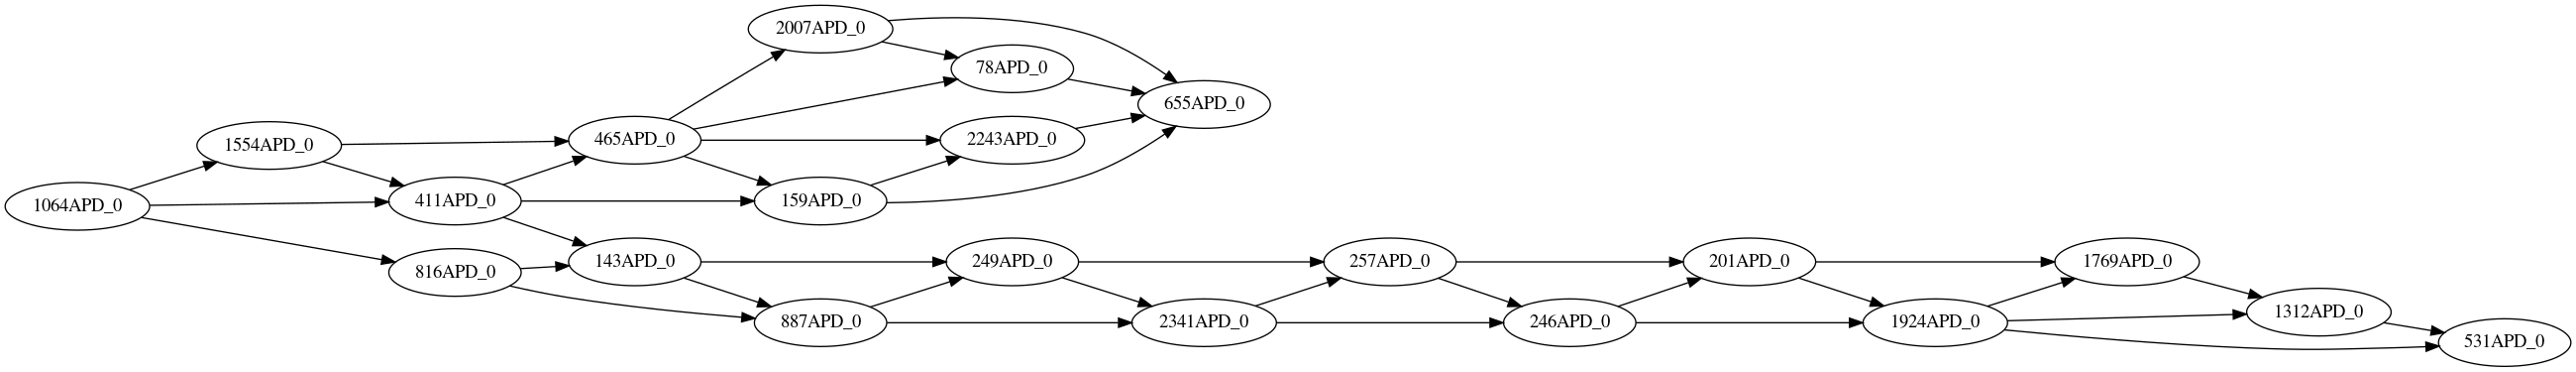

830APD_0


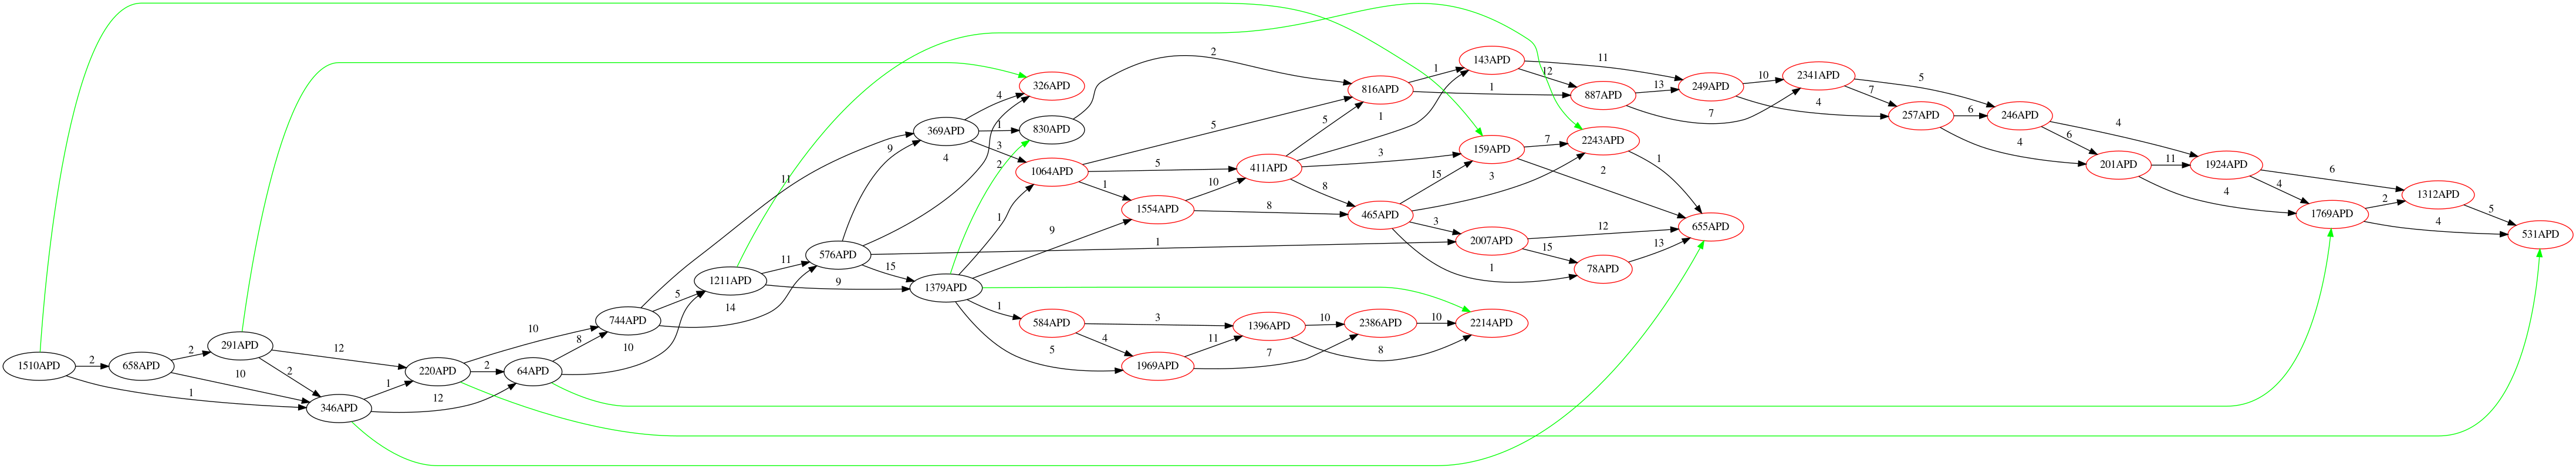

IndexError: list index out of range

In [10]:
a,b,c,d,e,f,g,h,i = subgraph
solve(a,b,c,d,e,f,g,h,i)

In [211]:
for e in graph2.in_edges('145APD_0', keys = True, data = 'gewicht'):
    print(e)

('1016APD_0', '145APD_0', 30986.0, 1)
('1074APD_0', '145APD_0', 23987.0, 1)
('113APD_0', '145APD_0', 2682.0, 1)
('113APD_0', '145APD_0', 6118.0, 1)
('1525APD_0', '145APD_0', 43087.0, 1)
('1952APD_0', '145APD_0', 55246.0, 1)
('198APD_0', '145APD_0', 49916.0, 1)
('371APD_0', '145APD_0', 37086.0, 1)
('501APD_0', '145APD_0', 19312.0, 2)
('501APD_0', '145APD_0', 16031.0, 13)
('501APD_0', '145APD_0', 7918.0, 1)
('501APD_0', '145APD_0', 4019.0, 1)


In [ ]:
T [1]
[1] erg 1779 max 4485604 repeats 43
T [0]
T [0, 1]
T [0, 1, 1]
[0, 1, 1] erg 2018 max 4900115 repeats 44
T [0, 1, 0]
[0, 1, 0] erg 2017 max 4863732 repeats 43
T [0, 0]
[0, 0] erg 2015 max 4863737 repeats 43